In [136]:
#__IMPORTAMOS TODAS LAS LIBRERIAS NECESARIAS__
import pandas as pd
import csv
import requests
import re
import ast
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
import numpy as np
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
from numpy import var
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import math
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [137]:
# podemos llamar con nuestro csv el dataset para que la Api si algun dia falla, no nos dañe el proyecto
dff = pd.read_csv('dff.csv')

In [138]:
# Convertimos el dataframe en DATATIME
dff.time = pd.to_datetime(dff.time)
dff

,time,price
0,2017-08-17,4261.48
1,2017-08-18,4285.08
2,2017-08-19,4108.37
3,2017-08-20,4120.98
4,2017-08-21,4069.13
...,...,...
1976,2023-01-14,19930.01
1977,2023-01-15,20952.76
1978,2023-01-16,20872.99
1979,2023-01-17,21185.65


In [139]:
# Convertimos el indice la columna TIME
dff.index = pd.DatetimeIndex(dff["time"])
dff

,time,price
time,,
2017-08-17,2017-08-17,4261.48
2017-08-18,2017-08-18,4285.08
2017-08-19,2017-08-19,4108.37
2017-08-20,2017-08-20,4120.98
2017-08-21,2017-08-21,4069.13
...,...,...
2023-01-14,2023-01-14,19930.01
2023-01-15,2023-01-15,20952.76
2023-01-16,2023-01-16,20872.99


In [140]:
dff.dtypes

time     datetime64[ns]
price           float64
dtype: object

In [142]:
# Creamos una nueva columna con la escala logaritmica
dff["log10Y"] = dff["price"].apply(lambda x: math.log10(x))
dff

,time,price,log10Y
time,,,
2017-08-17,2017-08-17,4261.48,3.629560
2017-08-18,2017-08-18,4285.08,3.631959
2017-08-19,2017-08-19,4108.37,3.613670
2017-08-20,2017-08-20,4120.98,3.615001
2017-08-21,2017-08-21,4069.13,3.609502
...,...,...,...
2023-01-14,2023-01-14,19930.01,4.299508
2023-01-15,2023-01-15,20952.76,4.321241
2023-01-16,2023-01-16,20872.99,4.319585


# Split train + test

In [143]:
# Vamos a hacer un split entre train y test, teniendo en cuenta que, al tratarse de una 
# serie de tiempo, tenemos que poner shuffle=False

df_train, df_test = train_test_split(dff, test_size=0.1, random_state=42, shuffle=False)

In [144]:
df_train.tail()

,time,price,log10Y
time,,,
2022-06-29,2022-06-29,20281.28,4.307095
2022-06-30,2022-06-30,20123.00,4.303693
2022-07-01,2022-07-01,19942.21,4.299773
2022-07-02,2022-07-02,19279.80,4.285103
2022-07-03,2022-07-03,19252.82,4.284494


## Modelo de la media constante

In [145]:
# Empezaremos a usar unos modelos, para ver cual se comporta mejor.
# Modelo de la MEDIA CONSTANTE

# Calculamos el promedio, uniforme para todos
model_mean_pred = df_train['log10Y'].mean()

# La predicción es fija y es la misma para el set de testeo y de entrenamiento:
df_train["Mean"] = model_mean_pred
df_test["Mean"] = model_mean_pred

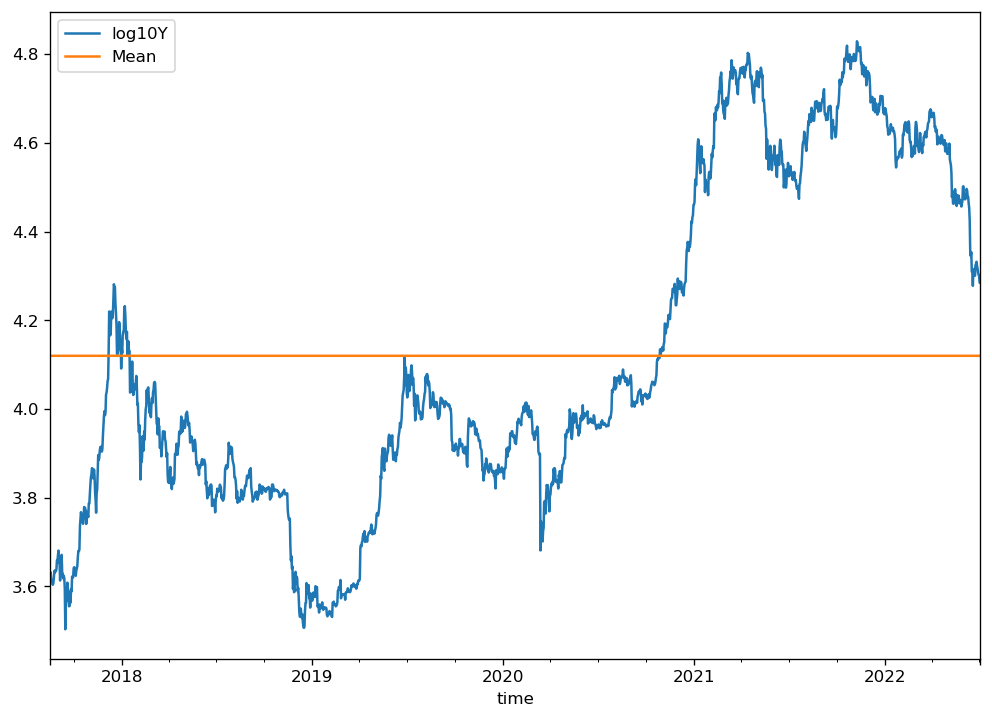

In [146]:
# Ploteamos los valores del set de entrenamiento y el modelo:
df_train.plot(kind="line", y = ["log10Y", "Mean"]);

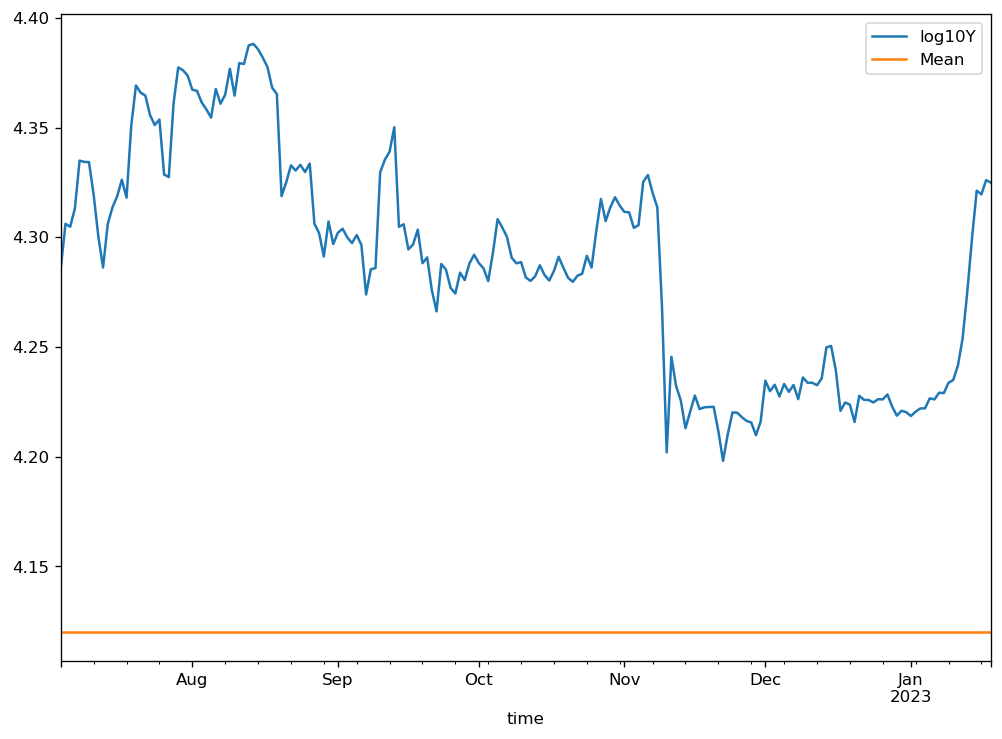

In [147]:
# Ploteamos los valores del set de testeo y el modelo
df_test.plot(kind="line", y = ["log10Y", "Mean"]);

In [148]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [149]:
model_mean_RMSE = RMSE(df_test.Mean, df_test.log10Y)
model_mean_RMSE

0.1751997088684568

In [150]:
# Guardamos todo en un dataframe
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Mean"
df_Results.loc[0, "RMSE"] = model_mean_RMSE
df_Results.head()

,Model,RMSE
0,Mean,0.1752


## Modelo de random walk

In [151]:
# Modelo de la Random Walk
# Generamos el desplazamiento de nuestro nuestro target en el set de entrenamiento (lag=1)
df_train["valueShift1"] = df_train.log10Y.shift()
df_train.head()

,time,price,log10Y,Mean,valueShift1
time,,,,,
2017-08-17,2017-08-17,4261.48,3.629560,4.120209,NaN
2017-08-18,2017-08-18,4285.08,3.631959,4.120209,3.629560
2017-08-19,2017-08-19,4108.37,3.613670,4.120209,3.631959
2017-08-20,2017-08-20,4120.98,3.615001,4.120209,3.613670
2017-08-21,2017-08-21,4069.13,3.609502,4.120209,3.615001


In [152]:
# Generamos el desplazamiento de nuestro nuestro target en el set de testeo (lag=1)
df_test["valueShift1"] = df_test.log10Y.shift()
df_test.head()

,time,price,log10Y,Mean,valueShift1
time,,,,,
2022-07-04,2022-07-04,19315.83,4.285913,4.120209,NaN
2022-07-05,2022-07-05,20236.71,4.306140,4.120209,4.285913
2022-07-06,2022-07-06,20175.84,4.304832,4.120209,4.306140
2022-07-07,2022-07-07,20564.51,4.313118,4.120209,4.304832
2022-07-08,2022-07-08,21624.99,4.334956,4.120209,4.313118


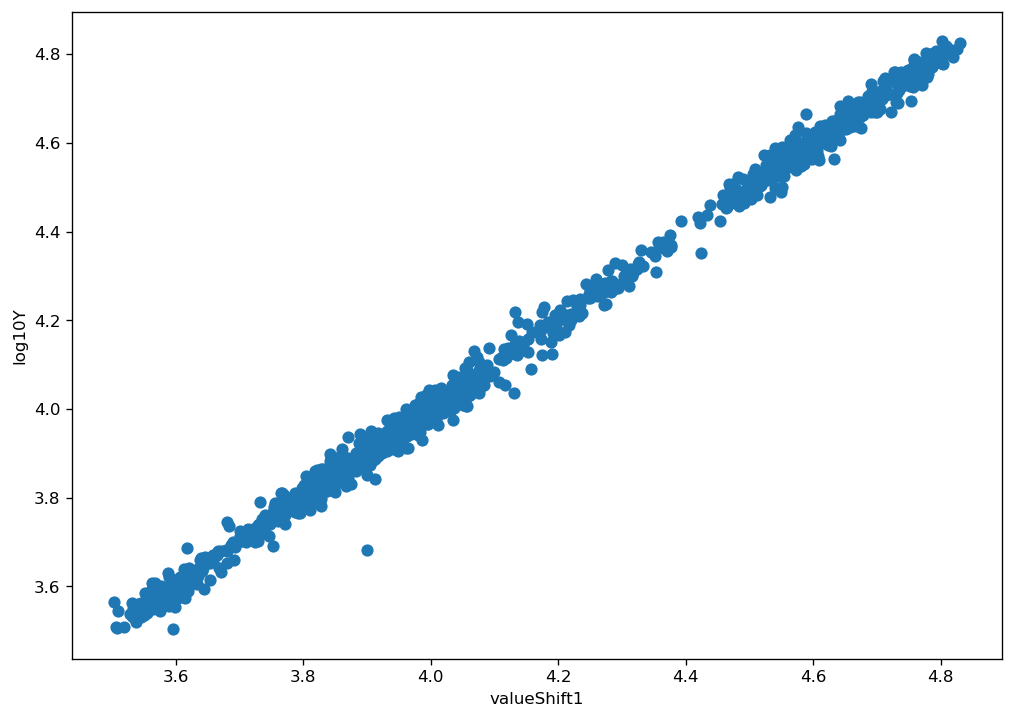

In [153]:
df_train.plot(kind= "scatter", y = "log10Y", x = "valueShift1", s = 40);

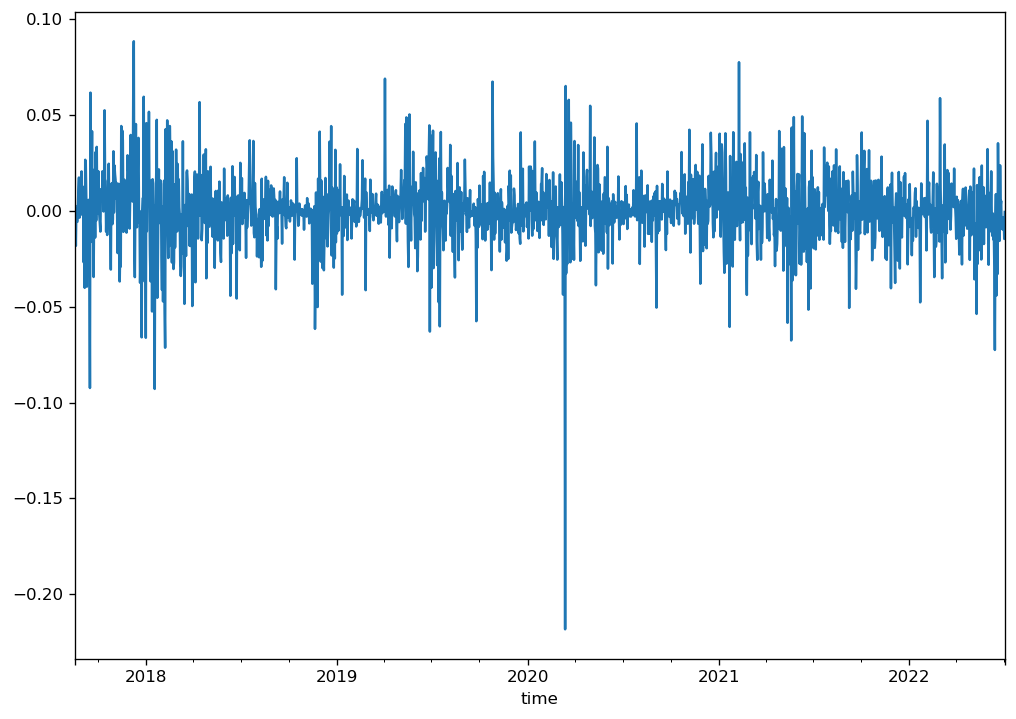

In [154]:
# Ploteamos la diferencia entre nuestro target y el lag de un período
df_train["valueDiff"] = df_train.log10Y - df_train.valueShift1
df_train.valueDiff.plot();

                 time     price    log10Y      Mean  valueShift1  valueDiff  \
time                                                                          
2017-08-17 2017-08-17   4261.48  3.629560  4.120209          NaN        NaN   
2017-08-18 2017-08-18   4285.08  3.631959  4.120209     3.629560   0.002398   
2017-08-19 2017-08-19   4108.37  3.613670  4.120209     3.631959  -0.018289   
2017-08-20 2017-08-20   4120.98  3.615001  4.120209     3.613670   0.001331   
2017-08-21 2017-08-21   4069.13  3.609502  4.120209     3.615001  -0.005499   
...               ...       ...       ...       ...          ...        ...   
2022-06-29 2022-06-29  20281.28  4.307095  4.120209     4.316863  -0.009767   
2022-06-30 2022-06-30  20123.00  4.303693  4.120209     4.307095  -0.003403   
2022-07-01 2022-07-01  19942.21  4.299773  4.120209     4.303693  -0.003919   
2022-07-02 2022-07-02  19279.80  4.285103  4.120209     4.299773  -0.014671   
2022-07-03 2022-07-03  19252.82  4.284494  4.120209 

<AxesSubplot:xlabel='time'>

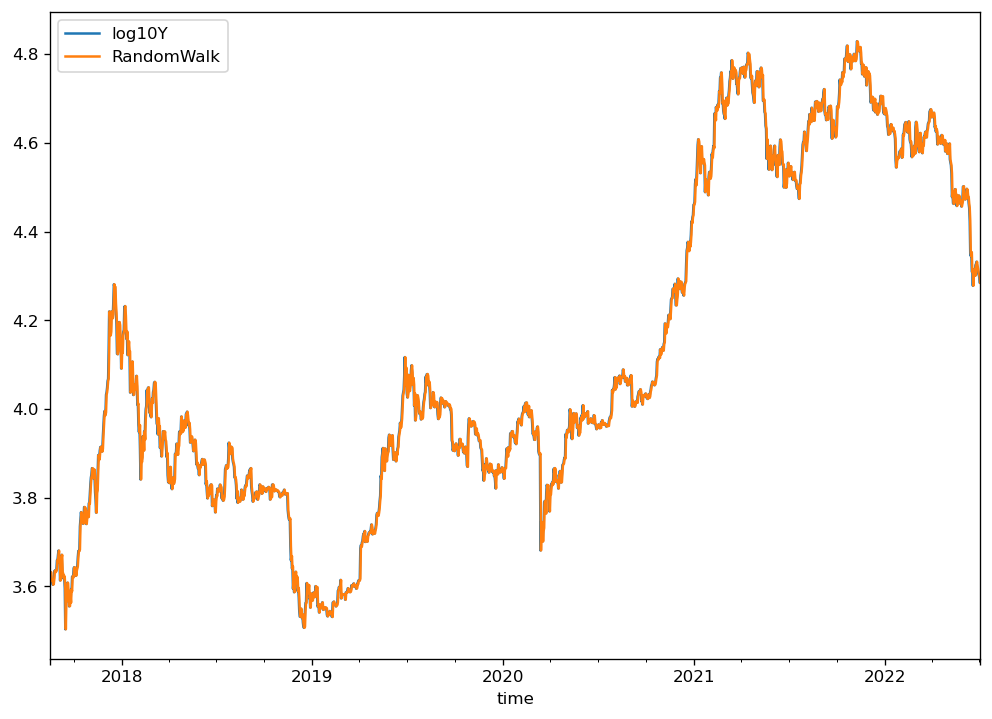

In [155]:
df_train["RandomWalk"] = df_train.valueShift1
print(df_train)

df_train.plot(kind="line", y = ["log10Y", "RandomWalk"])

In [156]:
# La predicción sobre el set de testeo es simplemente la última observación
# registrada en el set de entrenamiento.
# A partir de ahí, como la esperanza del shock es 0, y_t = y_t-1

df_test["RandomWalk"] = pd.Series(df_train["log10Y"][-1], index=df_test.index)
print(df_test["RandomWalk"])

time
2022-07-04    4.284494
2022-07-05    4.284494
2022-07-06    4.284494
2022-07-07    4.284494
2022-07-08    4.284494
                ...   
2023-01-14    4.284494
2023-01-15    4.284494
2023-01-16    4.284494
2023-01-17    4.284494
2023-01-18    4.284494
Name: RandomWalk, Length: 199, dtype: float64


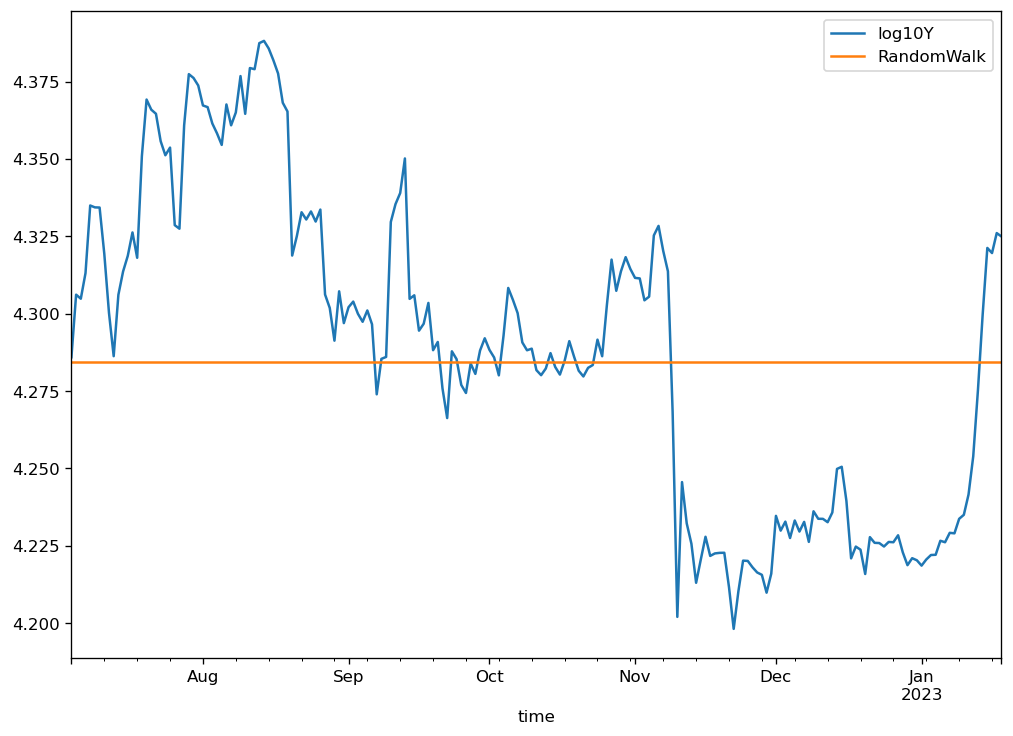

In [157]:
df_test.plot(kind="line", y = ["log10Y", "RandomWalk"]);

In [158]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[1, "Model"] = "RandomWalk"
df_Results.loc[1, "RMSE"] = RMSE(df_test.RandomWalk, df_test.log10Y)
df_Results

,Model,RMSE
0,Mean,0.1752
1,RandomWalk,0.050769


## Tendencia lineal

In [159]:
# Tendencia lineal
# Identificamos el punto de inicio de la data
df_train.index.min()

Timestamp('2017-08-17 00:00:00')

In [160]:
# Convertimos nuestra data almacenada en 'date' en datetime-delta, comenzando por cero
df_train["timeIndex"] = df_train.index - df_train.index.min()
df_test["timeIndex"] = df_test.index - df_train.index.min()

In [161]:
# Transformamos la última columna de días a meses con timedelta
df_train["timeIndex"] =  df_train["timeIndex"] / np.timedelta64(1, 'D')
df_test["timeIndex"] =  df_test["timeIndex"] / np.timedelta64(1, 'D')

In [162]:
# Redondeamos, quitando todos los decimales
df_train["timeIndex"] = df_train["timeIndex"].round(0).astype(int)
df_test["timeIndex"] = df_test["timeIndex"].round(0).astype(int)

In [163]:
df_train.tail()

,time,price,log10Y,Mean,valueShift1,valueDiff,RandomWalk,timeIndex
time,,,,,,,,
2022-06-29,2022-06-29,20281.28,4.307095,4.120209,4.316863,-0.009767,4.316863,1777
2022-06-30,2022-06-30,20123.00,4.303693,4.120209,4.307095,-0.003403,4.307095,1778
2022-07-01,2022-07-01,19942.21,4.299773,4.120209,4.303693,-0.003919,4.303693,1779
2022-07-02,2022-07-02,19279.80,4.285103,4.120209,4.299773,-0.014671,4.299773,1780
2022-07-03,2022-07-03,19252.82,4.284494,4.120209,4.285103,-0.000608,4.285103,1781


In [164]:
# Ahora fiteamos nuestro modelo de regresión lineal entre Value y timeIndex
model_linear = smf.ols('log10Y	 ~ timeIndex', data = df_train).fit()

In [165]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log10Y   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     3390.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:28:07   Log-Likelihood:                 166.78
No. Observations:                1782   AIC:                            -329.6
Df Residuals:                    1780   BIC:                            -318.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5938      0.010    344.196      0.000       3.573       3.614
timeIndex      0.0006   1.02e-05     58.220      0.000       0.001       0.001
==============================================================================
Omnibus:                      113.808   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.481
Skew:                           0.219   Prob(JB):                     4.02e-12
Kurtosis:                       2.283   Cond. No.                     2.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [166]:
# Veamos las predicciones del modelo sobre el set de entrenamiento:

model_linear_pred_train = model_linear.predict(df_train.timeIndex)
model_linear_pred_train[-5:]

time
2022-06-29    4.644215
2022-06-30    4.644806
2022-07-01    4.645397
2022-07-02    4.645988
2022-07-03    4.646579
dtype: float64

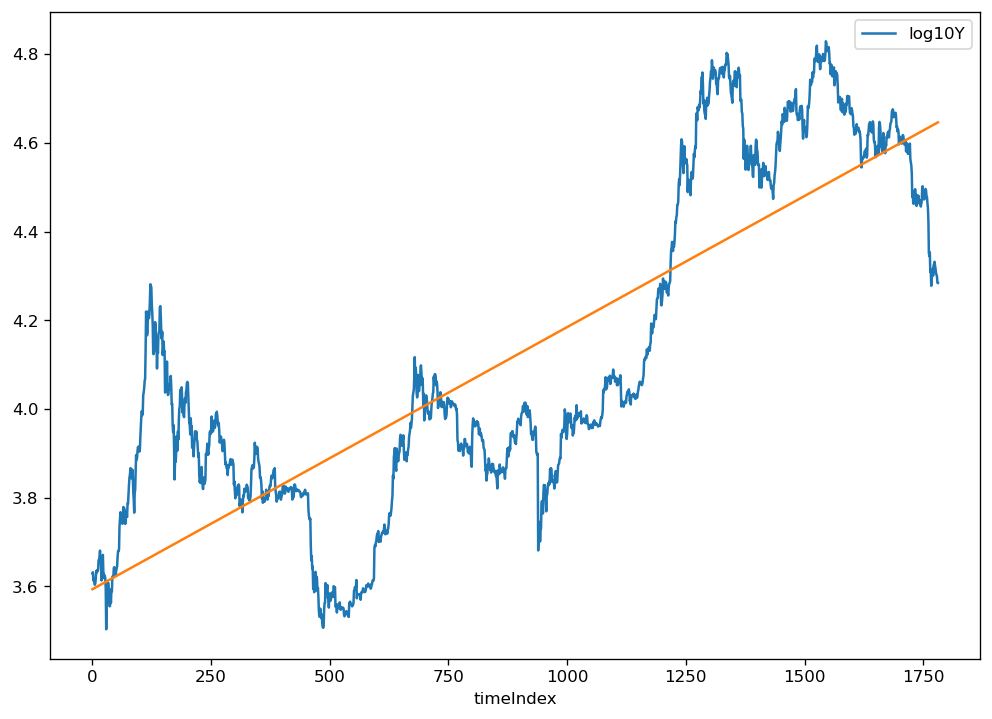

In [167]:
# Ploteamos los resultados de la predicción
df_train.plot(kind = "line", x = "timeIndex", y = "log10Y")
plt.plot(df_train.timeIndex, model_linear_pred_train, '-');

In [168]:
# Veamos las predicciones del modelo sobre el set de testeo:

model_linear_pred_test = model_linear.predict(df_test.timeIndex)
model_linear_pred_test[-5:]

time
2023-01-14    4.761843
2023-01-15    4.762434
2023-01-16    4.763025
2023-01-17    4.763616
2023-01-18    4.764207
dtype: float64

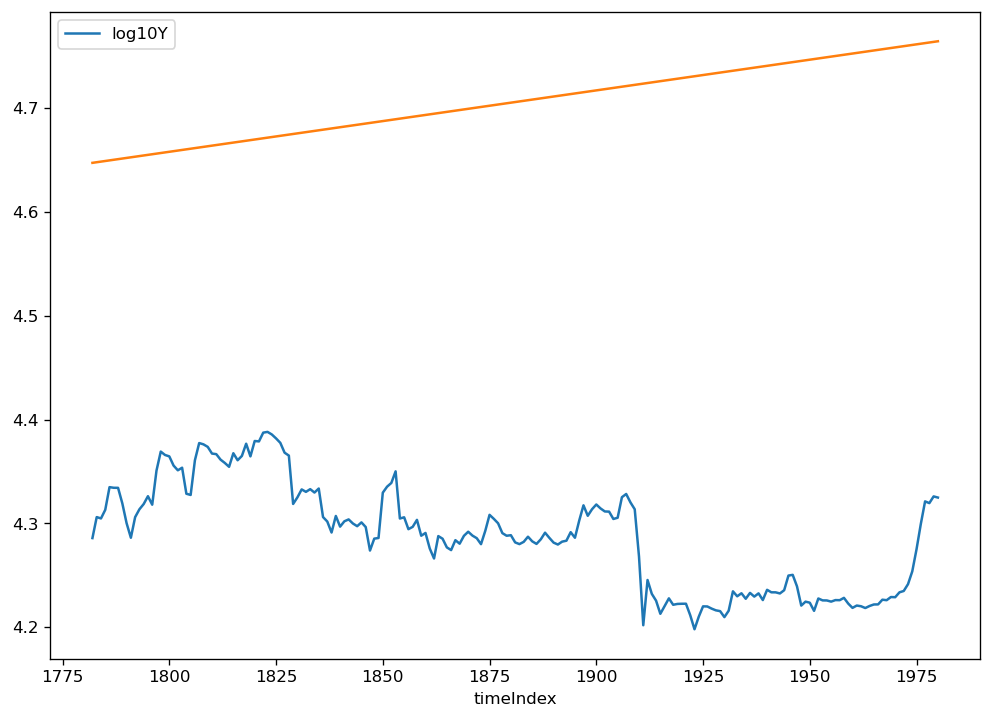

In [169]:
# Ploteamos los resultados de la predicción

df_test.plot(kind = "line", x = "timeIndex", y = "log10Y")
plt.plot(df_test.timeIndex, model_linear_pred_test, '-');

In [170]:
# Agregamos las predicciones a df_test:

df_test["LinearTrend"] = model_linear_pred_test
df_test.head()

,time,price,log10Y,Mean,valueShift1,RandomWalk,timeIndex,LinearTrend
time,,,,,,,,
2022-07-04,2022-07-04,19315.83,4.285913,4.120209,NaN,4.284494,1782,4.647171
2022-07-05,2022-07-05,20236.71,4.306140,4.120209,4.285913,4.284494,1783,4.647762
2022-07-06,2022-07-06,20175.84,4.304832,4.120209,4.306140,4.284494,1784,4.648353
2022-07-07,2022-07-07,20564.51,4.313118,4.120209,4.304832,4.284494,1785,4.648944
2022-07-08,2022-07-08,21624.99,4.334956,4.120209,4.313118,4.284494,1786,4.649535


In [171]:
# Calculamos el error:

model_linear_RMSE = RMSE(df_test.LinearTrend, df_test.log10Y)
model_linear_RMSE

0.4253351676016984

In [172]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior

df_Results.loc[2, "Model"] = "LinearTrend"
df_Results.loc[2, "RMSE"] = model_linear_RMSE
df_Results

,Model,RMSE
0,Mean,0.1752
1,RandomWalk,0.050769
2,LinearTrend,0.425335


## Tendencia cuadratica

In [173]:
# Tendencia cuadrática
# Creamos las dummies de tiempo cuadráticas:

df_train["timeIndex_sq"] = df_train["timeIndex"]**2
df_test["timeIndex_sq"] = df_test["timeIndex"]**2

In [174]:
# Ahora fiteamos nuestro modelo de regresión lineal entre value y timeIndex + timeIndex_sq

model_quadratic = smf.ols('log10Y ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [175]:
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log10Y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2420.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:30:46   Log-Likelihood:                 387.54
No. Observations:                1782   AIC:                            -769.1
Df Residuals:                    1779   BIC:                            -752.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.8243      0.014    276.495      0.000       3.797       3.851
timeIndex       -0.0002   3.59e-05     -5.175      0.000      -0.000      -0.000
timeIndex_sq  4.361e-07   1.95e-08     22.365      0.000    3.98e-07    4.74e-07
==============================================================================
Omnibus:                        3.573   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                3.625
Skew:                           0.107   Prob(JB):                        0.163
Kurtosis:                       2.946   Cond. No.                     4.25e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [176]:
# Veamos las predicciones del modelo sobre el set de entrenamiento:

model_quadratic_pred_train = model_quadratic.predict(df_train[["timeIndex",\
                                                      "timeIndex_sq"]])
model_quadratic_pred_train[-5:]

time
2022-06-29    4.871546
2022-06-30    4.872911
2022-07-01    4.874277
2022-07-02    4.875643
2022-07-03    4.877011
dtype: float64

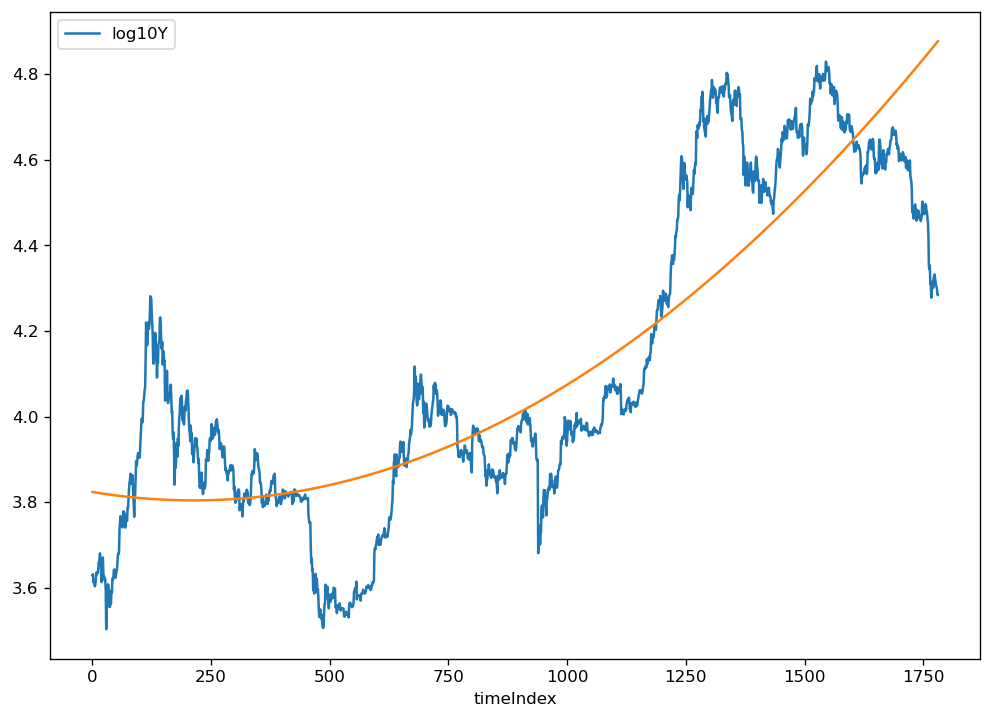

In [177]:
# Ploteamos los resultados de la predicción en el entrenamiento:

df_train.plot(kind = "line", x = "timeIndex", y = "log10Y")
plt.plot(df_train.timeIndex, model_quadratic_pred_train, '-');

In [178]:
# Veamos las predicciones del modelo sobre el set de testeo:

model_quadratic_pred_test = model_quadratic.predict(df_test[["timeIndex",\
                                                      "timeIndex_sq"]])
model_quadratic_pred_test[-5:]

time
2023-01-14    5.160321
2023-01-15    5.161859
2023-01-16    5.163398
2023-01-17    5.164939
2023-01-18    5.166480
dtype: float64

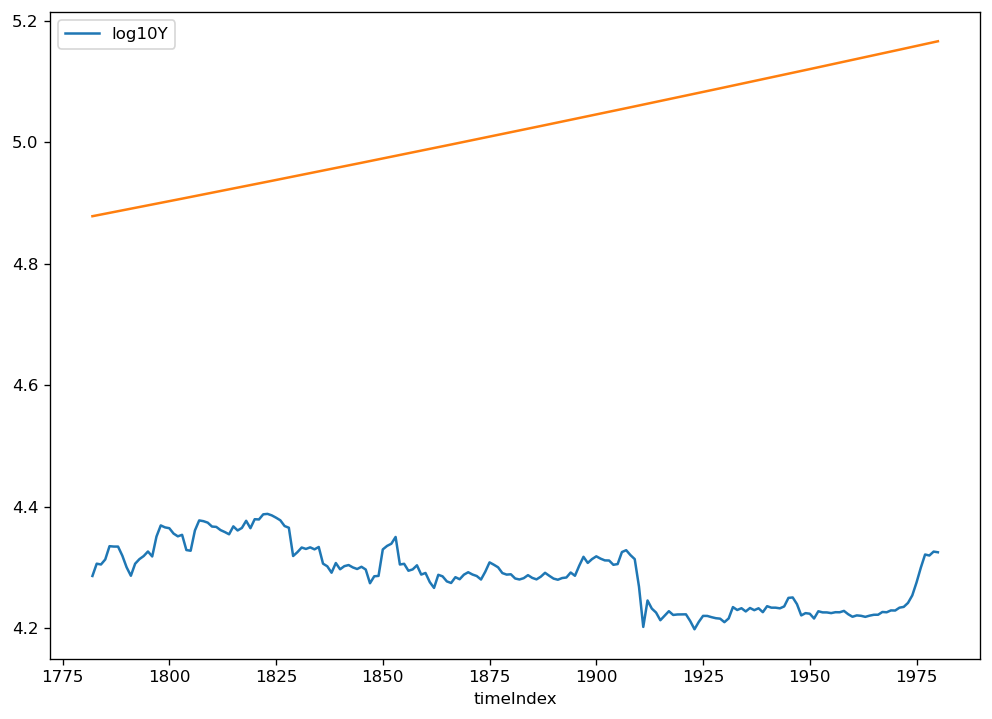

In [179]:
# Ploteamos los resultados de la predicción

df_test.plot(kind = "line", x = "timeIndex", y = "log10Y")
plt.plot(df_test.timeIndex, model_quadratic_pred_test, '-');

In [180]:
df_test["QuadraticTrend"] = model_quadratic_pred_test
df_test.head()

,time,price,log10Y,Mean,valueShift1,RandomWalk,timeIndex,LinearTrend,timeIndex_sq,QuadraticTrend
time,,,,,,,,,,
2022-07-04,2022-07-04,19315.83,4.285913,4.120209,NaN,4.284494,1782,4.647171,3175524,4.878379
2022-07-05,2022-07-05,20236.71,4.306140,4.120209,4.285913,4.284494,1783,4.647762,3179089,4.879748
2022-07-06,2022-07-06,20175.84,4.304832,4.120209,4.306140,4.284494,1784,4.648353,3182656,4.881118
2022-07-07,2022-07-07,20564.51,4.313118,4.120209,4.304832,4.284494,1785,4.648944,3186225,4.882489
2022-07-08,2022-07-08,21624.99,4.334956,4.120209,4.313118,4.284494,1786,4.649535,3189796,4.883861


In [181]:
# Calculamos el error:

model_quadratic_RMSE = RMSE(df_test.QuadraticTrend, df_test.log10Y)
model_quadratic_RMSE

0.7425949467890107

In [182]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
df_Results.loc[3, "Model"] = "QuadraticTrend"
df_Results.loc[3, "RMSE"] = model_quadratic_RMSE
df_Results

,Model,RMSE
0,Mean,0.1752
1,RandomWalk,0.050769
2,LinearTrend,0.425335
3,QuadraticTrend,0.742595


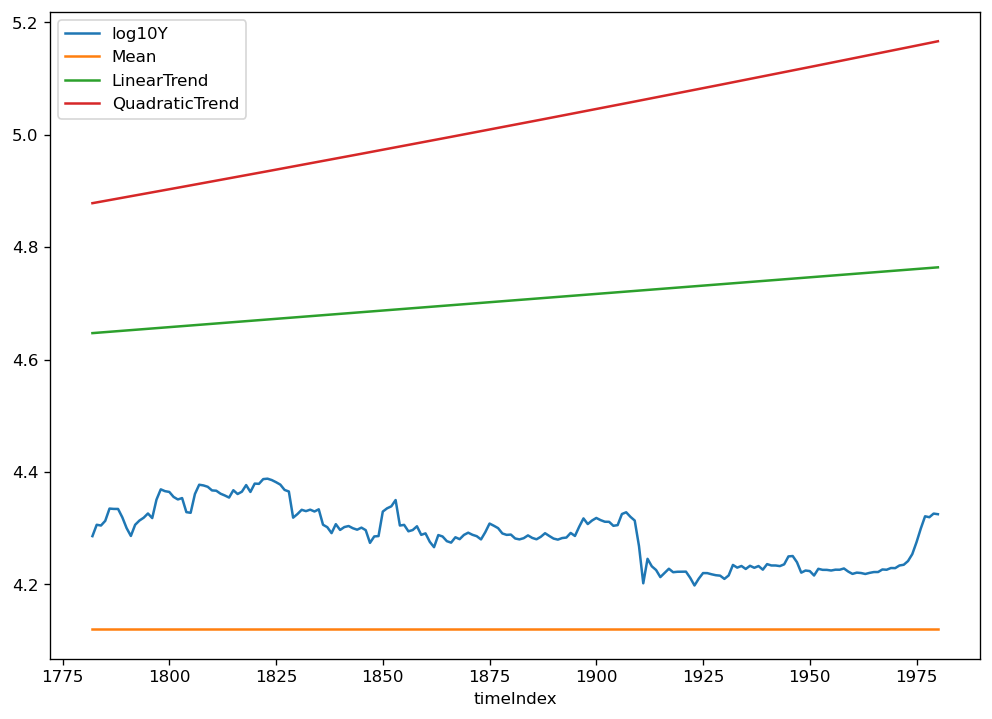

In [183]:
# Ploteamos todas las estimaciones
df_test.plot(kind = "line", x = "timeIndex", y = ["log10Y", "Mean",
                                                 "LinearTrend", "QuadraticTrend"]);

## Tendencia cuadratica + dummies

In [184]:
# Veamos el shape de nuestro df:
dff.shape

(1981, 3)

In [185]:
# Creamos la columna de los años tambien.
dff['Month'] = dff['time'].dt.month
dff

,time,price,log10Y,Month
time,,,,
2017-08-17,2017-08-17,4261.48,3.629560,8
2017-08-18,2017-08-18,4285.08,3.631959,8
2017-08-19,2017-08-19,4108.37,3.613670,8
2017-08-20,2017-08-20,4120.98,3.615001,8
2017-08-21,2017-08-21,4069.13,3.609502,8
...,...,...,...,...
2023-01-14,2023-01-14,19930.01,4.299508,1
2023-01-15,2023-01-15,20952.76,4.321241,1
2023-01-16,2023-01-16,20872.99,4.319585,1


In [186]:
# Creamos variables dummie para los meses:
dummie_mes = pd.get_dummies(dff['Month'], prefix='mes', drop_first=True)
dummie_mes.head()

,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
time,,,,,,,,,,,
2017-08-17,0,0,0,0,0,0,1,0,0,0,0
2017-08-18,0,0,0,0,0,0,1,0,0,0,0
2017-08-19,0,0,0,0,0,0,1,0,0,0,0
2017-08-20,0,0,0,0,0,0,1,0,0,0,0
2017-08-21,0,0,0,0,0,0,1,0,0,0,0


In [187]:
df = dff.join(dummie_mes)
df.sample(10)

,time,price,log10Y,Month,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
time,,,,,,,,,,,,,,,
2018-05-27,2018-05-27,7334.00,3.865341,5,0,0,0,1,0,0,0,0,0,0,0
2018-12-11,2018-12-11,3434.01,3.535802,12,0,0,0,0,0,0,0,0,0,0,1
2018-05-08,2018-05-08,9365.00,3.971508,5,0,0,0,1,0,0,0,0,0,0,0
2017-10-31,2017-10-31,6120.52,3.786788,10,0,0,0,0,0,0,0,0,1,0,0
2019-08-29,2019-08-29,9721.00,3.987711,8,0,0,0,0,0,0,1,0,0,0,0
2022-10-26,2022-10-26,20079.02,4.302743,10,0,0,0,0,0,0,0,0,1,0,0
2019-12-04,2019-12-04,7292.71,3.862889,12,0,0,0,0,0,0,0,0,0,0,1
2020-12-05,2020-12-05,18650.51,4.270691,12,0,0,0,0,0,0,0,0,0,0,1
2019-06-18,2019-06-18,9312.13,3.969049,6,0,0,0,0,1,0,0,0,0,0,0


In [188]:
df_train = df_train.join(dummie_mes)

In [189]:
# Ahora fiteamos nuestro modelo de regresión lineal entre value y timeIndex + timeIndex_sq
# más las dummies de mes

model_trend_est = smf.ols('log10Y ~ timeIndex + timeIndex_sq + mes_2 + mes_3 + mes_4 + mes_5 + mes_7 + mes_8 + mes_9 + mes_10 + mes_11 + mes_11',\
                          data = df_train).fit()

In [190]:
model_trend_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log10Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     441.8
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:31:34   Log-Likelihood:                 393.54
No. Observations:                1782   AIC:                            -763.1
Df Residuals:                    1770   BIC:                            -697.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.8214      0.016    239.147      0.000       3.790       3.853
timeIndex       -0.0002   3.61e-05     -5.319      0.000      -0.000      -0.000
timeIndex_sq  4.397e-07   1.96e-08     22.432      0.000    4.01e-07    4.78e-07
mes_2            0.0264      0.019      1.410      0.159      -0.010       0.063
mes_3           -0.0006      0.018     -0.034      0.973      -0.036       0.035
mes_4           -0.0014      0.018     -0.079      0.937      -0.037       0.034
mes_5           -0.0068      0.018     -0.377      0.706      -0.042       0.029
mes_7            0.0148      0.020      0.756      0.450      -0.024       0.053
mes_8            0.0309      0.019      1.638      0.102      -0.006       0.068
mes_9           -0.0252      0.018     -1.371      0.171      -0.061       0.011
mes_10          -0.0055      0.018     -0.306      0.760      -0.041       0.030
mes_11           0.0290      0.018      1.582      0.114      -0.007       0.065
==============================================================================
Omnibus:                        4.935   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.938
Skew:                           0.129   Prob(JB):                       0.0847
Kurtosis:                       2.992   Cond. No.                     1.01e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [191]:
# Veamos las predicciones del modelo sobre el set de entrenamiento:

model_trend_est_pred_train = model_trend_est.predict(df_train[["timeIndex", "timeIndex_sq",\
                                                               "mes_2", "mes_3", "mes_4", "mes_5",\
                                                                "mes_6", "mes_7",\
                                                                "mes_8", "mes_9", "mes_10",\
                                                                "mes_11"]])
model_trend_est_pred_train[-5:]

time
2022-06-29    4.868947
2022-06-30    4.870318
2022-07-01    4.886501
2022-07-02    4.887874
2022-07-03    4.889248
dtype: float64

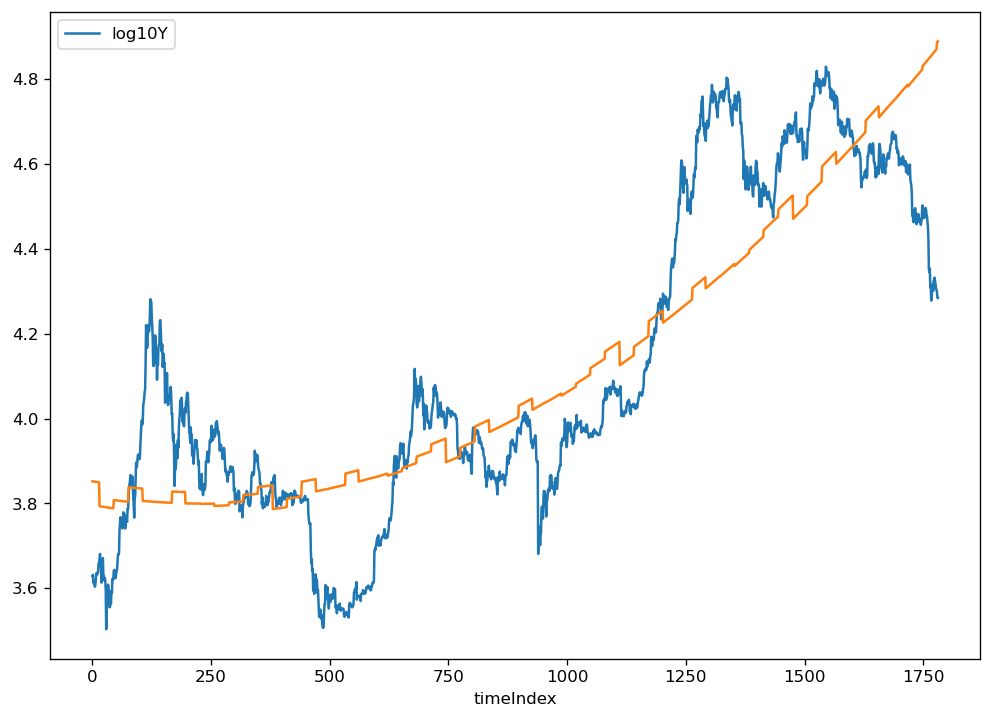

In [192]:
# Ploteamos los resultados de la predicción:

df_train.plot(kind = "line", x = "timeIndex", y = "log10Y")
plt.plot(df_train.timeIndex, model_trend_est_pred_train, '-');

In [193]:
df_test = df_test.join(dummie_mes)

In [194]:
# Veamos las predicciones del modelo sobre el set de testeo:

model_trend_est_pred_test = model_trend_est.predict(df_test[["timeIndex", "timeIndex_sq",\
                                                               "mes_2", "mes_3", "mes_4", "mes_5",\
                                                                "mes_6", "mes_7",\
                                                                "mes_8", "mes_9", "mes_10",\
                                                                "mes_11"]])
model_trend_est_pred_test[-5:]

time
2023-01-14    5.159162
2023-01-15    5.160708
2023-01-16    5.162255
2023-01-17    5.163803
2023-01-18    5.165352
dtype: float64

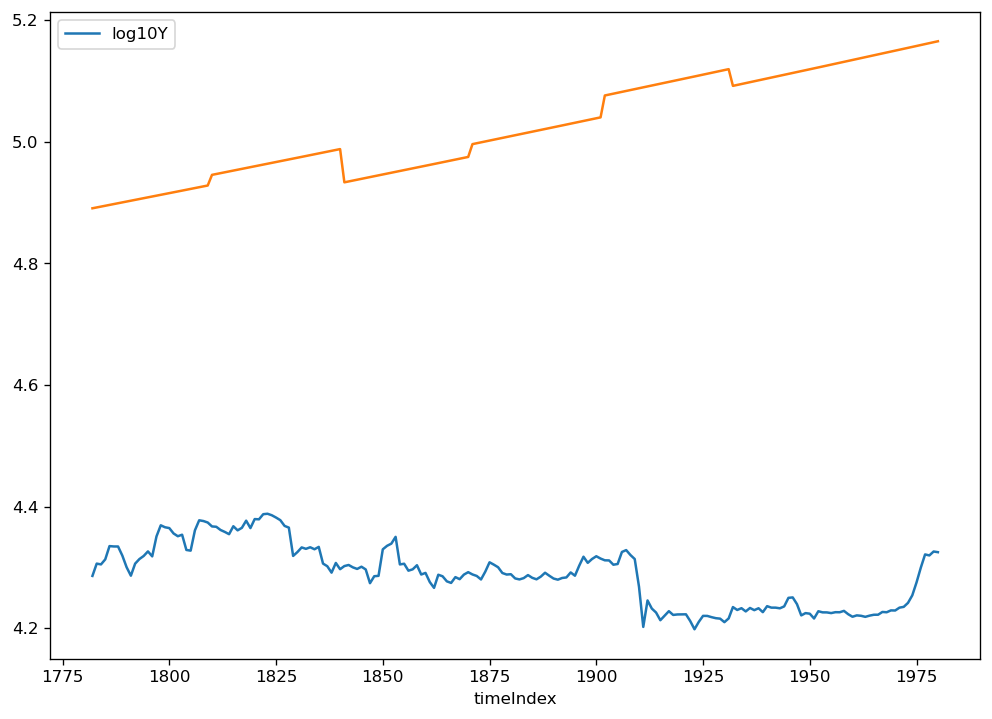

In [195]:
# Ploteamos los resultados de la predicción:

df_test.plot(kind = "line", x = "timeIndex", y = "log10Y")
plt.plot(df_test.timeIndex, model_trend_est_pred_test, '-');

In [196]:
# Calculamos el error:

df_test["Trend_Est"] = model_trend_est_pred_test
df_test.head()

,time,price,log10Y,Mean,valueShift1,RandomWalk,timeIndex,LinearTrend,timeIndex_sq,QuadraticTrend,...,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12,Trend_Est
time,,,,,,,,,,,,,,,,,,,,,
2022-07-04,2022-07-04,19315.83,4.285913,4.120209,NaN,4.284494,1782,4.647171,3175524,4.878379,...,0,0,0,1,0,0,0,0,0,4.890623
2022-07-05,2022-07-05,20236.71,4.306140,4.120209,4.285913,4.284494,1783,4.647762,3179089,4.879748,...,0,0,0,1,0,0,0,0,0,4.891999
2022-07-06,2022-07-06,20175.84,4.304832,4.120209,4.306140,4.284494,1784,4.648353,3182656,4.881118,...,0,0,0,1,0,0,0,0,0,4.893375
2022-07-07,2022-07-07,20564.51,4.313118,4.120209,4.304832,4.284494,1785,4.648944,3186225,4.882489,...,0,0,0,1,0,0,0,0,0,4.894753
2022-07-08,2022-07-08,21624.99,4.334956,4.120209,4.313118,4.284494,1786,4.649535,3189796,4.883861,...,0,0,0,1,0,0,0,0,0,4.896131


In [197]:
model_trend_est_RMSE = RMSE(df_test.Trend_Est, df_test.log10Y)
model_trend_est_RMSE

0.746959822820328

In [198]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
df_Results.loc[4, "Model"] = "Trend_Est"
df_Results.loc[4, "RMSE"] = model_trend_est_RMSE
df_Results

,Model,RMSE
0,Mean,0.1752
1,RandomWalk,0.050769
2,LinearTrend,0.425335
3,QuadraticTrend,0.742595
4,Trend_Est,0.74696


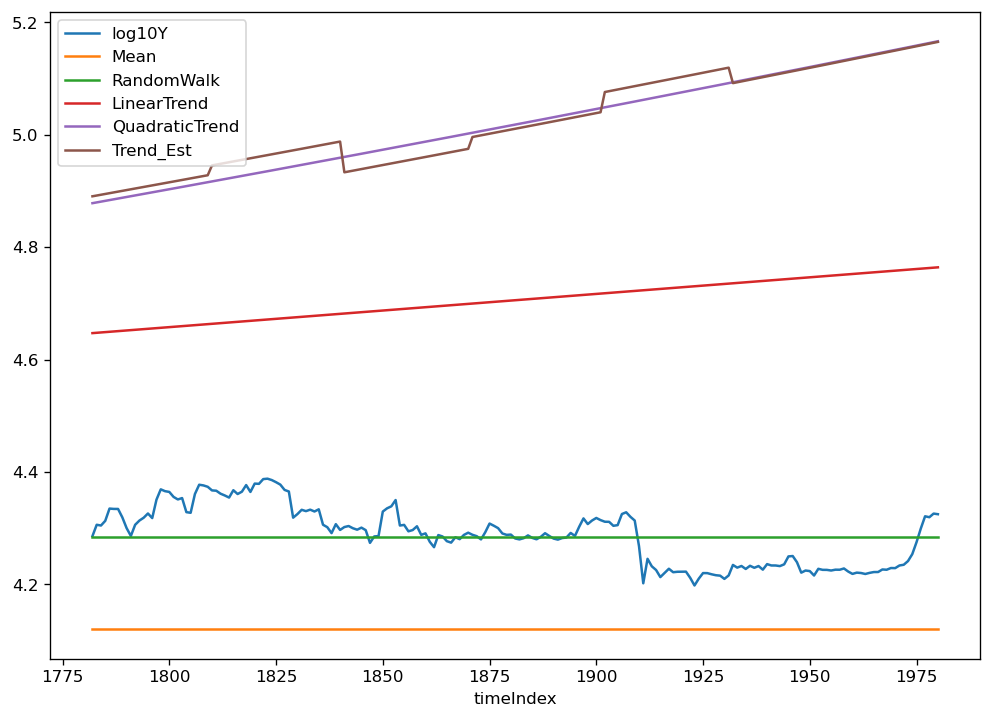

In [199]:
# Ploteamos todas las estimaciones
df_test.plot(kind = "line", x = "timeIndex", y = ["log10Y", "Mean", "RandomWalk",
                                                 "LinearTrend", "QuadraticTrend",\
                                                 "Trend_Est"]);

In [65]:
import datetime
start = datetime.date(2023,1,19)
periods = 3000
daterange = []
for day in range(periods):
  date = (start + datetime.timedelta(days = day)).isoformat()
  daterange.append(date)
print(daterange)

['2023-01-19', '2023-01-20', '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28', '2023-01-29', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-04', '2023-02-05', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-11', '2023-02-12', '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-18', '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26', '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-25', '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023

In [66]:
df = pd.DataFrame({'time': daterange})

In [67]:
df

,time
0,2023-01-19
1,2023-01-20
2,2023-01-21
3,2023-01-22
4,2023-01-23
...,...
2995,2031-04-02
2996,2031-04-03
2997,2031-04-04
2998,2031-04-05


In [68]:
# Convertir celdas de texto en celdas de tipo datetime
df['time'] = pd.to_datetime(df['time'])

In [69]:
df.dtypes

time    datetime64[ns]
dtype: object

In [70]:
df["price"] = np.nan
df

,time,price
0,2023-01-19,NaN
1,2023-01-20,NaN
2,2023-01-21,NaN
3,2023-01-22,NaN
4,2023-01-23,NaN
...,...,...
2995,2031-04-02,NaN
2996,2031-04-03,NaN
2997,2031-04-04,NaN
2998,2031-04-05,NaN


In [71]:
# Convertimos el indice la columna TIME
df.index = pd.DatetimeIndex(df["time"])
df

,time,price
time,,
2023-01-19,2023-01-19,NaN
2023-01-20,2023-01-20,NaN
2023-01-21,2023-01-21,NaN
2023-01-22,2023-01-22,NaN
2023-01-23,2023-01-23,NaN
...,...,...
2031-04-02,2031-04-02,NaN
2031-04-03,2031-04-03,NaN
2031-04-04,2031-04-04,NaN


In [72]:
# CONCATENAMOS LOS DOS DATAFRAME
dfn = pd.concat([dff, df], ignore_index=True)
dfn

,time,price,log10Y,Month
0,2017-08-17,4261.48,3.629560,8.0
1,2017-08-18,4285.08,3.631959,8.0
2,2017-08-19,4108.37,3.613670,8.0
3,2017-08-20,4120.98,3.615001,8.0
4,2017-08-21,4069.13,3.609502,8.0
...,...,...,...,...
4976,2031-04-02,NaN,NaN,NaN
4977,2031-04-03,NaN,NaN,NaN
4978,2031-04-04,NaN,NaN,NaN
4979,2031-04-05,NaN,NaN,NaN


In [73]:
dfn = dfn.drop(["log10Y", "Month"], axis=1)
dfn

,time,price
0,2017-08-17,4261.48
1,2017-08-18,4285.08
2,2017-08-19,4108.37
3,2017-08-20,4120.98
4,2017-08-21,4069.13
...,...,...
4976,2031-04-02,NaN
4977,2031-04-03,NaN
4978,2031-04-04,NaN
4979,2031-04-05,NaN


In [74]:
# Convertimos el indice la columna TIME
dfn.index = pd.DatetimeIndex(dfn["time"])
dfn

,time,price
time,,
2017-08-17,2017-08-17,4261.48
2017-08-18,2017-08-18,4285.08
2017-08-19,2017-08-19,4108.37
2017-08-20,2017-08-20,4120.98
2017-08-21,2017-08-21,4069.13
...,...,...
2031-04-02,2031-04-02,NaN
2031-04-03,2031-04-03,NaN
2031-04-04,2031-04-04,NaN


In [75]:
#Split train + test
# Vamos a hacer un split entre train y test, teniendo en cuenta que, al tratarse de una 
# serie de tiempo, tenemos que poner shuffle=False

df_train, df_test = train_test_split(dfn, test_size=0.61, random_state=42, shuffle=False)

In [76]:
df_train.tail()

,time,price
time,,
2022-12-06,2022-12-06,16966.35
2022-12-07,2022-12-07,17088.96
2022-12-08,2022-12-08,16836.64
2022-12-09,2022-12-09,17224.10
2022-12-10,2022-12-10,17128.56


In [77]:
df_test.head()

,time,price
time,,
2022-12-11,2022-12-11,17127.49
2022-12-12,2022-12-12,17085.05
2022-12-13,2022-12-13,17208.93
2022-12-14,2022-12-14,17775.82
2022-12-15,2022-12-15,17804.01


In [78]:
# Empezaremos a usar unos modelos, para ver cual se comporta mejor.
# Modelo de la MEDIA CONSTANTE

# Calculamos el promedio, uniforme para todos
model_mean_pred = df_train['price'].mean()

# La predicción es fija y es la misma para el set de testeo y de entrenamiento:
df_train["Mean"] = model_mean_pred
df_test["Mean"] = model_mean_pred

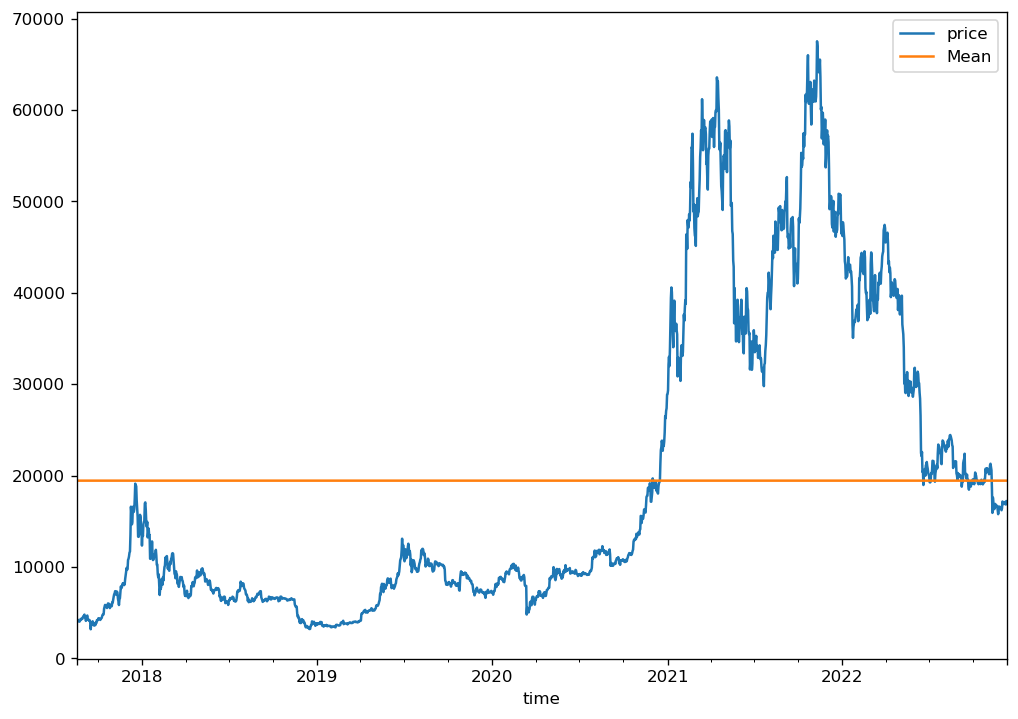

In [79]:
# Ploteamos los valores del set de entrenamiento y el modelo:
df_train.plot(kind="line", y = ["price", "Mean"]);

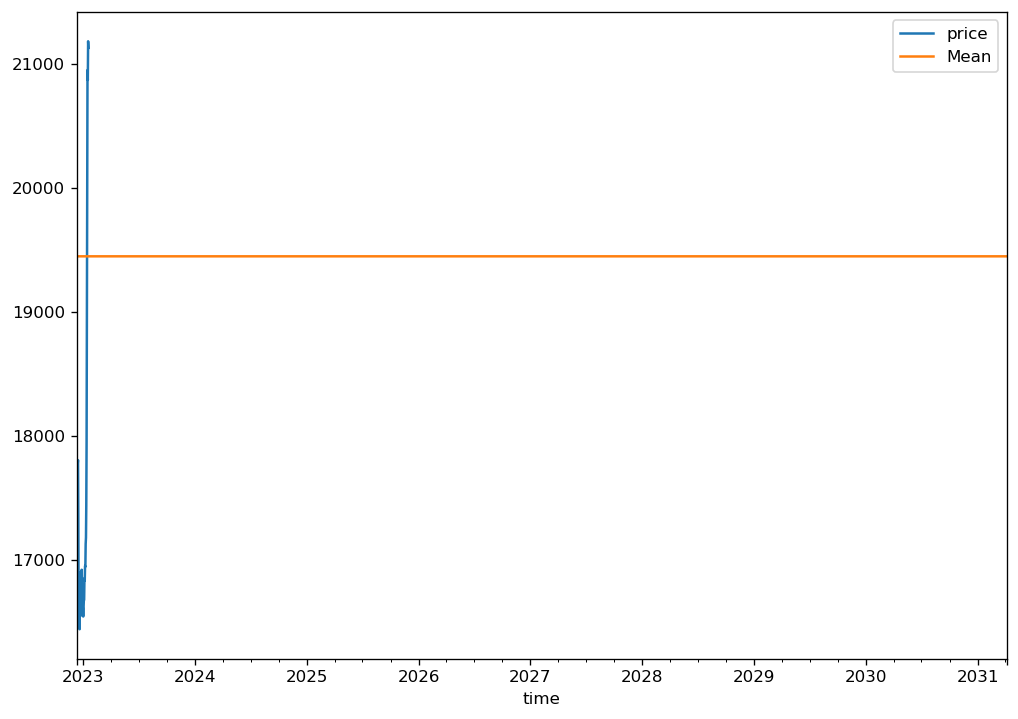

In [80]:
# Ploteamos los valores del set de testeo y el modelo
df_test.plot(kind="line", y = ["price", "Mean"]);

In [81]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [82]:
model_mean_RMSE = RMSE(df_test.Mean, df_test.price)
model_mean_RMSE

2388.349353520841

In [83]:
# Guardamos todo en un dataframe
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Mean"
df_Results.loc[0, "RMSE"] = model_mean_RMSE
df_Results.head()

,Model,RMSE
0,Mean,2388.349354


In [84]:
# Modelo de la Random Walk
# Generamos el desplazamiento de nuestro nuestro target en el set de entrenamiento (lag=1)
df_train["valueShift1"] = df_train.price.shift()
df_train.head()

,time,price,Mean,valueShift1
time,,,,
2017-08-17,2017-08-17,4261.48,19449.538903,NaN
2017-08-18,2017-08-18,4285.08,19449.538903,4261.48
2017-08-19,2017-08-19,4108.37,19449.538903,4285.08
2017-08-20,2017-08-20,4120.98,19449.538903,4108.37
2017-08-21,2017-08-21,4069.13,19449.538903,4120.98


In [85]:
# Generamos el desplazamiento de nuestro nuestro target en el set de testeo (lag=1)
df_test["valueShift1"] = df_test.price.shift()
df_test.head()

,time,price,Mean,valueShift1
time,,,,
2022-12-11,2022-12-11,17127.49,19449.538903,NaN
2022-12-12,2022-12-12,17085.05,19449.538903,17127.49
2022-12-13,2022-12-13,17208.93,19449.538903,17085.05
2022-12-14,2022-12-14,17775.82,19449.538903,17208.93
2022-12-15,2022-12-15,17804.01,19449.538903,17775.82


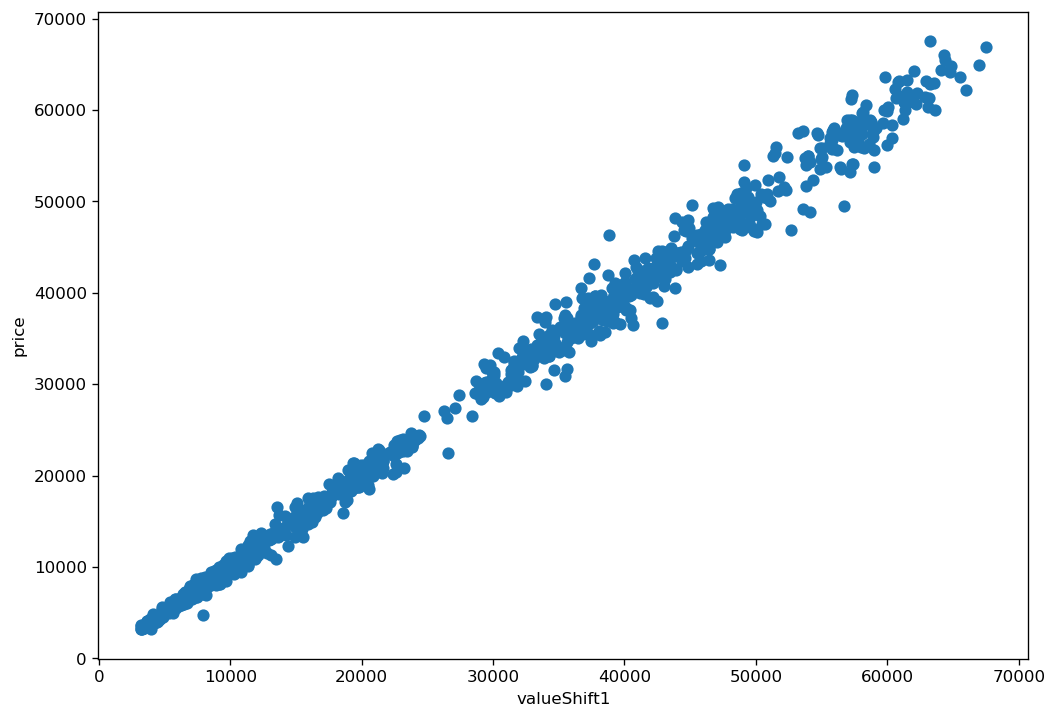

In [86]:
df_train.plot(kind= "scatter", y = "price", x = "valueShift1", s = 40);

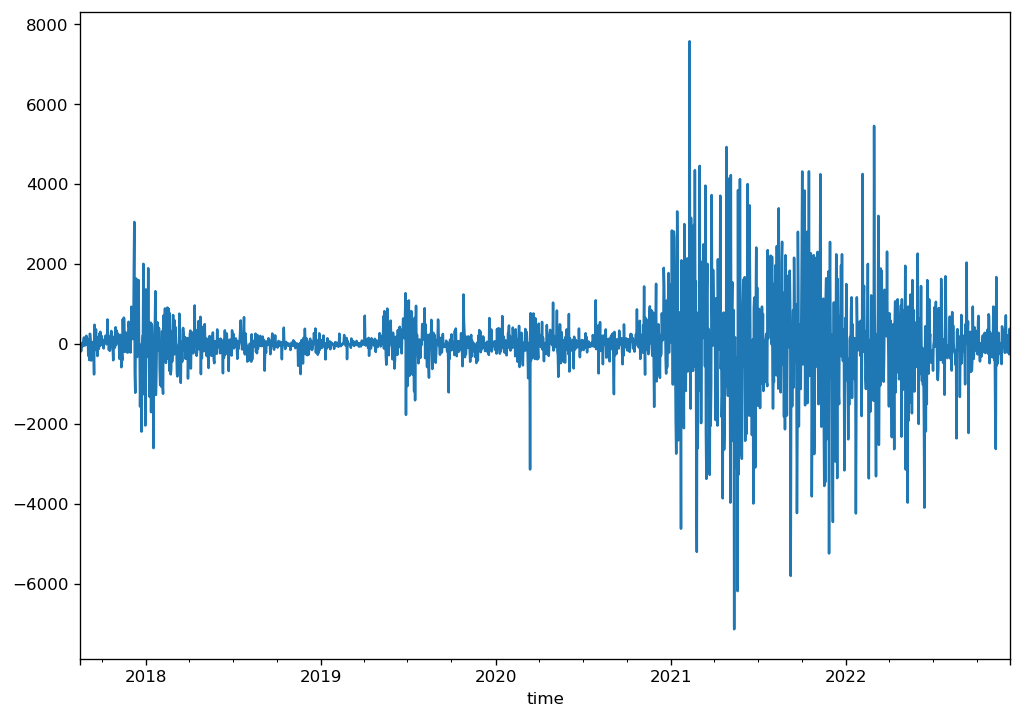

In [87]:
# Ploteamos la diferencia entre nuestro target y el lag de un período
df_train["valueDiff"] = df_train.price - df_train.valueShift1
df_train.valueDiff.plot();

                 time     price          Mean  valueShift1  valueDiff  \
time                                                                    
2017-08-17 2017-08-17   4261.48  19449.538903          NaN        NaN   
2017-08-18 2017-08-18   4285.08  19449.538903      4261.48      23.60   
2017-08-19 2017-08-19   4108.37  19449.538903      4285.08    -176.71   
2017-08-20 2017-08-20   4120.98  19449.538903      4108.37      12.61   
2017-08-21 2017-08-21   4069.13  19449.538903      4120.98     -51.85   
...               ...       ...           ...          ...        ...   
2022-12-06 2022-12-06  16966.35  19449.538903     17106.65    -140.30   
2022-12-07 2022-12-07  17088.96  19449.538903     16966.35     122.61   
2022-12-08 2022-12-08  16836.64  19449.538903     17088.96    -252.32   
2022-12-09 2022-12-09  17224.10  19449.538903     16836.64     387.46   
2022-12-10 2022-12-10  17128.56  19449.538903     17224.10     -95.54   

            RandomWalk  
time                    


<AxesSubplot:xlabel='time'>

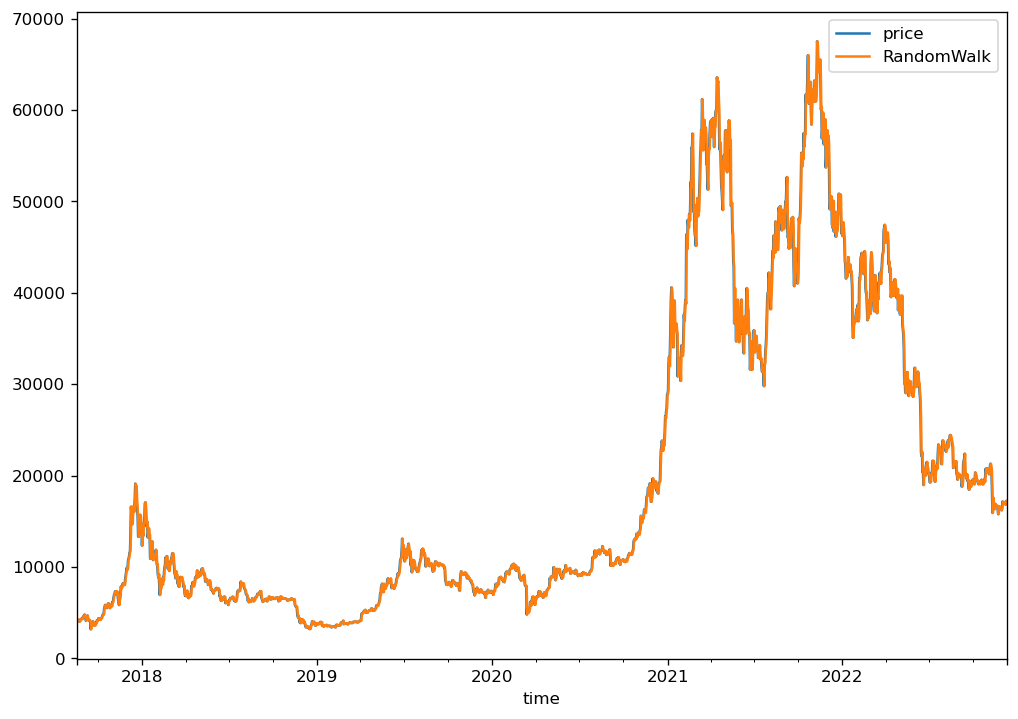

In [88]:
df_train["RandomWalk"] = df_train.valueShift1
print(df_train)

df_train.plot(kind="line", y = ["price", "RandomWalk"])

In [89]:
# La predicción sobre el set de testeo es simplemente la última observación
# registrada en el set de entrenamiento.
# A partir de ahí, como la esperanza del shock es 0, y_t = y_t-1

df_test["RandomWalk"] = pd.Series(df_train["price"][1], index=df_test.index)
print(df_test["RandomWalk"])

time
2022-12-11    4285.08
2022-12-12    4285.08
2022-12-13    4285.08
2022-12-14    4285.08
2022-12-15    4285.08
               ...   
2031-04-02    4285.08
2031-04-03    4285.08
2031-04-04    4285.08
2031-04-05    4285.08
2031-04-06    4285.08
Name: RandomWalk, Length: 3039, dtype: float64


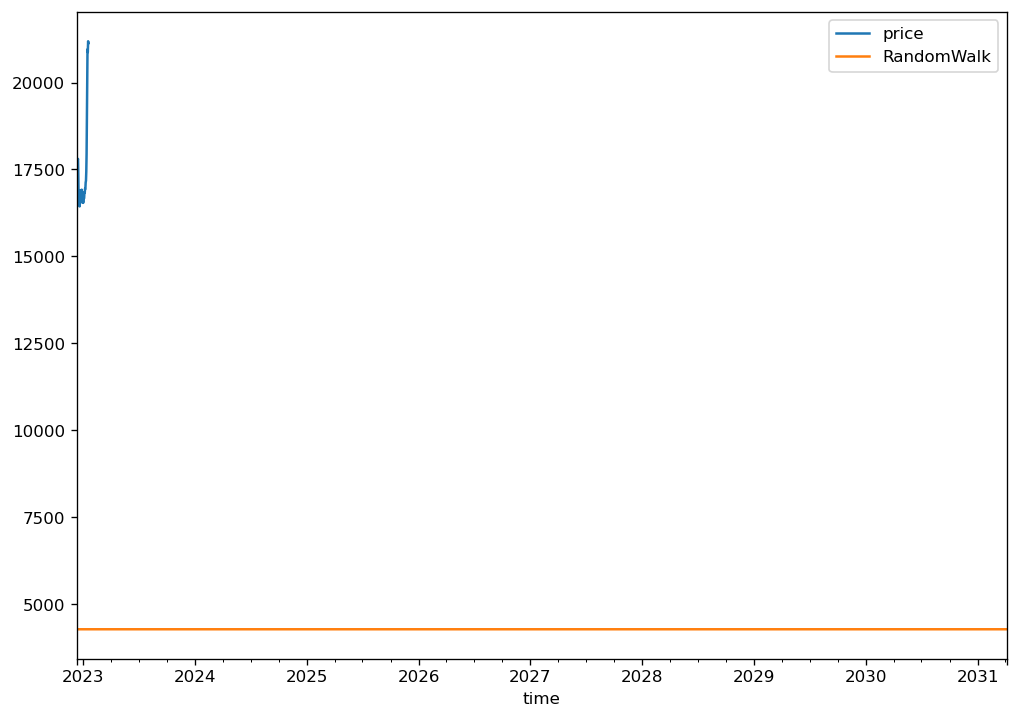

In [90]:
df_test.plot(kind="line", y = ["price", "RandomWalk"]);

In [91]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[1, "Model"] = "RandomWalk"
df_Results.loc[1, "RMSE"] = RMSE(df_test.RandomWalk, df_test.price)
df_Results

,Model,RMSE
0,Mean,2388.349354
1,RandomWalk,13273.359525


In [92]:
# Tendencia lineal
# Identificamos el punto de inicio de la data
df_train.index.min()

Timestamp('2017-08-17 00:00:00')

In [93]:
# Convertimos nuestra data almacenada en 'date' en datetime-delta, comenzando por cero
df_train["timeIndex"] = df_train.index - df_train.index.min()
df_test["timeIndex"] = df_test.index - df_train.index.min()

In [94]:
# Transformamos la última columna de días a meses con timedelta
df_train["timeIndex"] =  df_train["timeIndex"] / np.timedelta64(1, 'D')
df_test["timeIndex"] =  df_test["timeIndex"] / np.timedelta64(1, 'D')

In [95]:
# Redondeamos, quitando todos los decimales
df_train["timeIndex"] = df_train["timeIndex"].round(0).astype(int)
df_test["timeIndex"] = df_test["timeIndex"].round(0).astype(int)

In [96]:
# Ahora fiteamos nuestro modelo de regresión lineal entre Value y timeIndex
model_linear = smf.ols('price ~ timeIndex', data = df_train).fit()

In [97]:
# Veamos las predicciones del modelo sobre el set de entrenamiento:

model_linear_pred_train = model_linear.predict(df_train.timeIndex)
model_linear_pred_train[-5:]

time
2022-12-06    39085.474844
2022-12-07    39105.791384
2022-12-08    39126.107924
2022-12-09    39146.424464
2022-12-10    39166.741004
dtype: float64

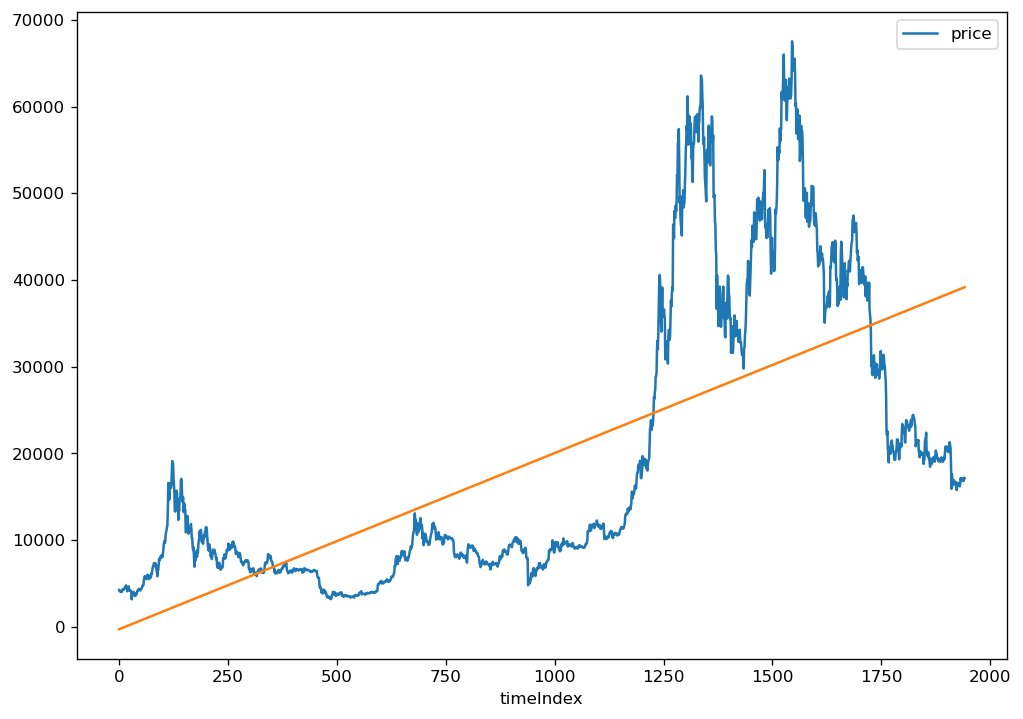

In [98]:
# Ploteamos los resultados de la predicción
df_train.plot(kind = "line", x = "timeIndex", y = "price")
plt.plot(df_train.timeIndex, model_linear_pred_train, '-');

In [99]:
# Veamos las predicciones del modelo sobre el set de testeo:

model_linear_pred_test = model_linear.predict(df_test.timeIndex)
model_linear_pred_test[-5:]

time
2031-04-02    100827.44000
2031-04-03    100847.75654
2031-04-04    100868.07308
2031-04-05    100888.38962
2031-04-06    100908.70616
dtype: float64

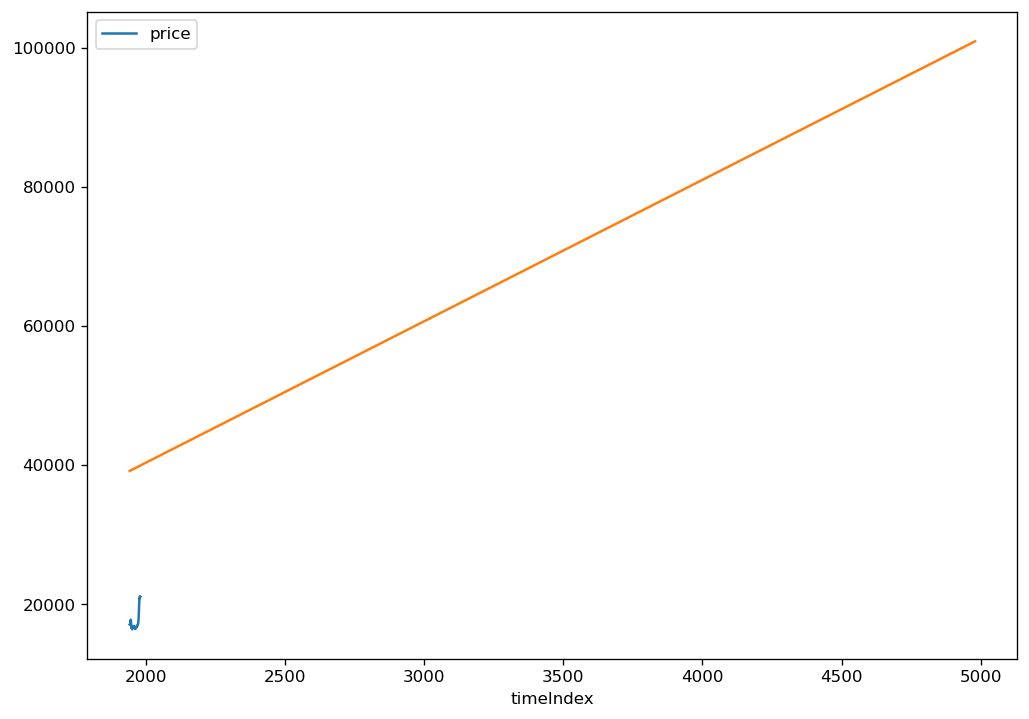

In [100]:
# Ploteamos los resultados de la predicción

df_test.plot(kind = "line", x = "timeIndex", y = "price")
plt.plot(df_test.timeIndex, model_linear_pred_test, '-');

In [101]:
# Agregamos las predicciones a df_test:

df_test["LinearTrend"] = model_linear_pred_test
df_test.head()

,time,price,Mean,valueShift1,RandomWalk,timeIndex,LinearTrend
time,,,,,,,
2022-12-11,2022-12-11,17127.49,19449.538903,NaN,4285.08,1942,39187.057544
2022-12-12,2022-12-12,17085.05,19449.538903,17127.49,4285.08,1943,39207.374084
2022-12-13,2022-12-13,17208.93,19449.538903,17085.05,4285.08,1944,39227.690624
2022-12-14,2022-12-14,17775.82,19449.538903,17208.93,4285.08,1945,39248.007164
2022-12-15,2022-12-15,17804.01,19449.538903,17775.82,4285.08,1946,39268.323704


In [102]:
# Calculamos el error:

model_linear_RMSE = RMSE(df_test.LinearTrend, df_test.price)
model_linear_RMSE

22119.709545607016

In [103]:
# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior

df_Results.loc[2, "Model"] = "LinearTrend"
df_Results.loc[2, "RMSE"] = model_linear_RMSE
df_Results

,Model,RMSE
0,Mean,2388.349354
1,RandomWalk,13273.359525
2,LinearTrend,22119.709546


In [104]:
# Tendencia cuadrática
# Creamos las dummies de tiempo cuadráticas:

df_train["timeIndex_sq"] = df_train["timeIndex"]**2
df_test["timeIndex_sq"] = df_test["timeIndex"]**2

In [105]:
# Ahora fiteamos nuestro modelo de regresión lineal entre value y timeIndex + timeIndex_sq

model_quadratic = smf.ols('price ~ timeIndex + timeIndex_sq', data = df_train).fit()

In [106]:
# Veamos las predicciones del modelo sobre el set de entrenamiento:

model_quadratic_pred_train = model_quadratic.predict(df_train[["timeIndex",\
                                                      "timeIndex_sq"]])
model_quadratic_pred_train[-5:]

time
2022-12-06    39983.434110
2022-12-07    40006.552418
2022-12-08    40029.673623
2022-12-09    40052.797725
2022-12-10    40075.924725
dtype: float64

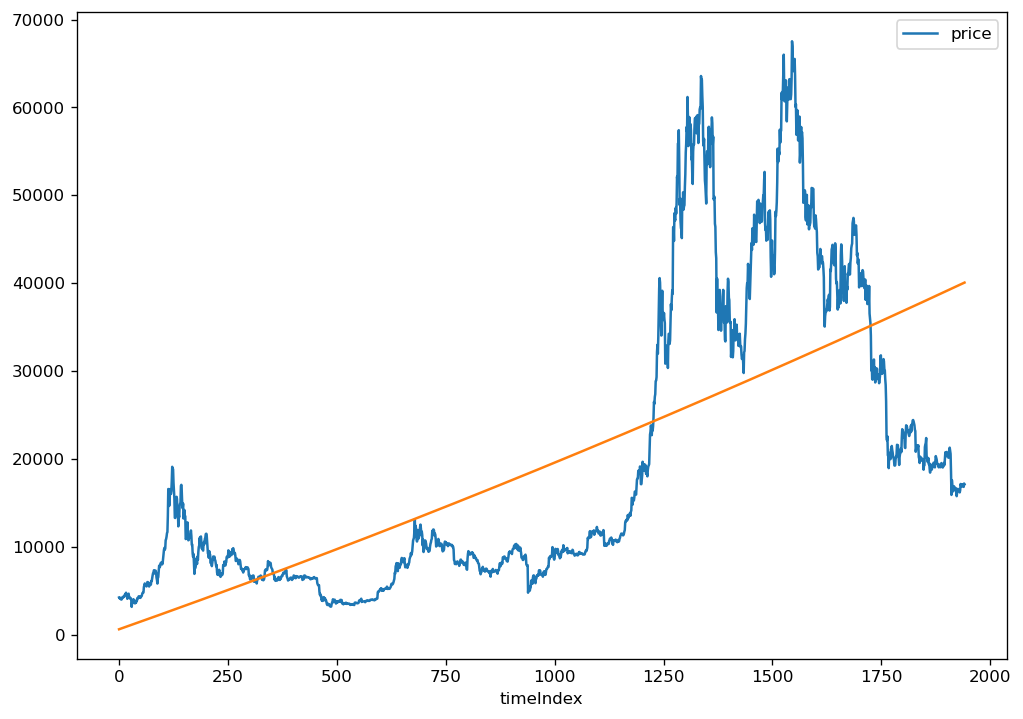

In [107]:
# Ploteamos los resultados de la predicción:

df_train.plot(kind = "line", x = "timeIndex", y = "price")
plt.plot(df_train.timeIndex, model_quadratic_pred_train, '-');

In [108]:
# Veamos las predicciones del modelo sobre el set de testeo:

model_quadratic_pred_test = model_quadratic.predict(df_test[["timeIndex",\
                                                      "timeIndex_sq"]])
model_quadratic_pred_test[-5:]

time
2031-04-02    123614.980640
2031-04-03    123646.904089
2031-04-04    123678.830435
2031-04-05    123710.759679
2031-04-06    123742.691820
dtype: float64

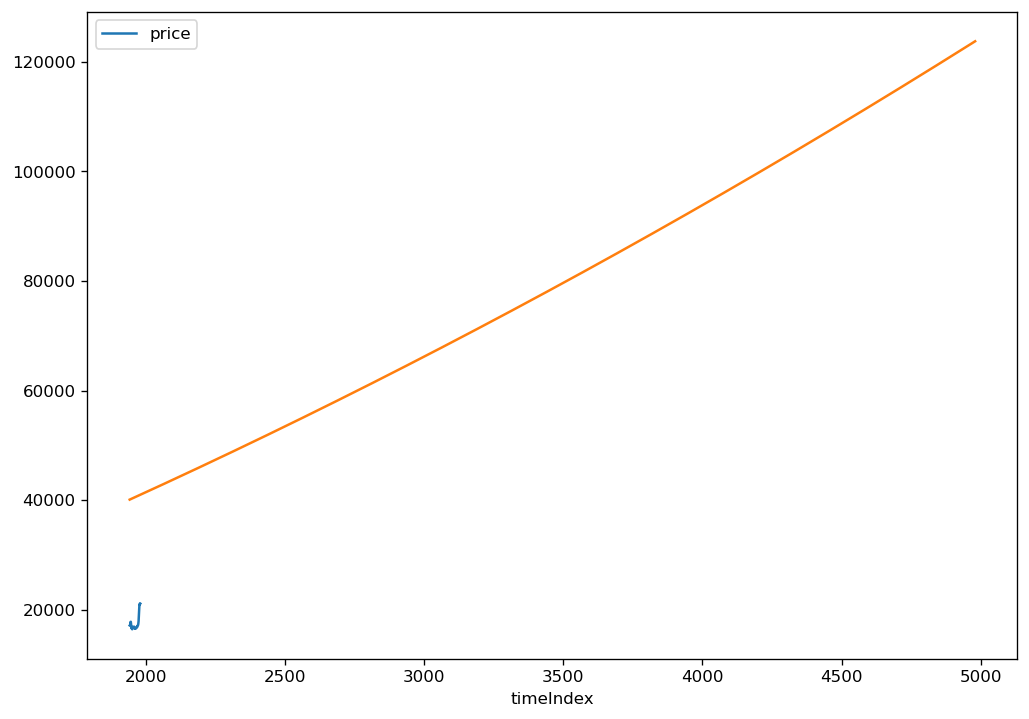

In [109]:
# Ploteamos los resultados de la predicción

df_test.plot(kind = "line", x = "timeIndex", y = "price")
plt.plot(df_test.timeIndex, model_quadratic_pred_test, '-');

In [133]:
df_test["QuadraticTrend"] = model_quadratic_pred_test
df_test.head()

,time,price,Mean,valueShift1,RandomWalk,timeIndex,LinearTrend,timeIndex_sq,QuadraticTrend
time,,,,,,,,,
2022-12-11,2022-12-11,17127.49,19449.538903,NaN,4285.08,1942,39187.057544,3771364,40099.054622
2022-12-12,2022-12-12,17085.05,19449.538903,17127.49,4285.08,1943,39207.374084,3775249,40122.187416
2022-12-13,2022-12-13,17208.93,19449.538903,17085.05,4285.08,1944,39227.690624,3779136,40145.323108
2022-12-14,2022-12-14,17775.82,19449.538903,17208.93,4285.08,1945,39248.007164,3783025,40168.461697
2022-12-15,2022-12-15,17804.01,19449.538903,17775.82,4285.08,1946,39268.323704,3786916,40191.603184


In [134]:
# Calculamos el error:

model_quadratic_RMSE = RMSE(df_test.QuadraticTrend, df_test.price)
model_quadratic_RMSE

AttributeError: 'DataFrame' object has no attribute 'value'

In [110]:
# Creamos la columna trimestre en el dataframe
dfn['trimestre'] = dfn['time'].dt.quarter
dfn

,time,price,trimestre
time,,,
2017-08-17,2017-08-17,4261.48,3
2017-08-18,2017-08-18,4285.08,3
2017-08-19,2017-08-19,4108.37,3
2017-08-20,2017-08-20,4120.98,3
2017-08-21,2017-08-21,4069.13,3
...,...,...,...
2031-04-02,2031-04-02,NaN,2
2031-04-03,2031-04-03,NaN,2
2031-04-04,2031-04-04,NaN,2


In [111]:
# Creamos la columna de los años tambien.
dfn['year'] = dfn['time'].dt.year
dfn

,time,price,trimestre,year
time,,,,
2017-08-17,2017-08-17,4261.48,3,2017
2017-08-18,2017-08-18,4285.08,3,2017
2017-08-19,2017-08-19,4108.37,3,2017
2017-08-20,2017-08-20,4120.98,3,2017
2017-08-21,2017-08-21,4069.13,3,2017
...,...,...,...,...
2031-04-02,2031-04-02,NaN,2,2031
2031-04-03,2031-04-03,NaN,2,2031
2031-04-04,2031-04-04,NaN,2,2031


In [112]:
# Creamos la columna de los años tambien.
dfn['month'] = dfn['time'].dt.month
dfn

,time,price,trimestre,year,month
time,,,,,
2017-08-17,2017-08-17,4261.48,3,2017,8
2017-08-18,2017-08-18,4285.08,3,2017,8
2017-08-19,2017-08-19,4108.37,3,2017,8
2017-08-20,2017-08-20,4120.98,3,2017,8
2017-08-21,2017-08-21,4069.13,3,2017,8
...,...,...,...,...,...
2031-04-02,2031-04-02,NaN,2,2031,4
2031-04-03,2031-04-03,NaN,2,2031,4
2031-04-04,2031-04-04,NaN,2,2031,4


In [113]:
# Para generar los 16 trimestres(4 años) de la estaionalidad de bitcoin, generamos esta nueva columna a base de la formula: 
dfn["trimestre16"] = (dfn["year"] * 12 + dfn["month"])%16

In [114]:
dfn

,time,price,trimestre,year,month,trimestre16
time,,,,,,
2017-08-17,2017-08-17,4261.48,3,2017,8,4
2017-08-18,2017-08-18,4285.08,3,2017,8,4
2017-08-19,2017-08-19,4108.37,3,2017,8,4
2017-08-20,2017-08-20,4120.98,3,2017,8,4
2017-08-21,2017-08-21,4069.13,3,2017,8,4
...,...,...,...,...,...,...
2031-04-02,2031-04-02,NaN,2,2031,4,8
2031-04-03,2031-04-03,NaN,2,2031,4,8
2031-04-04,2031-04-04,NaN,2,2031,4,8


In [115]:
# Generamos las dummies de la columna Tirmestre16
dummie_Tri = pd.get_dummies(dfn['trimestre16'], drop_first=True)
dummie_Tri.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
time,,,,,,,,,,,,,,,
2017-08-17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-20,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-21,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [116]:
# Concatenamos o unimos los dummies y el DataFrame
df = dfn.join(dummie_Tri)
df.sample(10)

,time,price,trimestre,year,month,trimestre16,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
time,,,,,,,,,,,,,,,,,,,,,
2023-09-03,2023-09-03,NaN,3,2023,9,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2031-03-11,2031-03-11,NaN,1,2031,3,7,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2022-05-27,2022-05-27,29201.35,2,2022,5,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2030-02-16,2030-02-16,NaN,1,2030,2,10,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2025-11-22,2025-11-22,NaN,4,2025,11,7,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2021-07-27,2021-07-27,37241.33,3,2021,7,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2030-12-06,2030-12-06,NaN,4,2030,12,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2019-07-02,2019-07-02,10624.90,3,2019,7,11,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2019-04-10,2019-04-10,5150.00,2,2019,4,8,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [117]:
# Vamos a cambiar el nombre de las columnas para que sea mas facil identificarlas.
df.columns = ["time", 'price', 'trimestre', 'year', "Month", "trimestre16", "t1", "t2", "t3", "t4", "t5", "t6", "t7", "t8", "t9", "t10", "t11", "t12", "t13", "t14", "t15"]
df

,time,price,trimestre,year,Month,trimestre16,t1,t2,t3,t4,...,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15
time,,,,,,,,,,,,,,,,,,,,,
2017-08-17,2017-08-17,4261.48,3,2017,8,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2017-08-18,2017-08-18,4285.08,3,2017,8,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2017-08-19,2017-08-19,4108.37,3,2017,8,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2017-08-20,2017-08-20,4120.98,3,2017,8,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2017-08-21,2017-08-21,4069.13,3,2017,8,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031-04-02,2031-04-02,NaN,2,2031,4,8,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2031-04-03,2031-04-03,NaN,2,2031,4,8,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2031-04-04,2031-04-04,NaN,2,2031,4,8,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [118]:
# Dividimos de nuevo el dataframe en train y test.
df16_train, df16_test = train_test_split(df, test_size=0.65, random_state=42, shuffle=False)

In [119]:
# Identificamos el punto de inicio de la data
df16_train.index.min()

Timestamp('2017-08-17 00:00:00')

In [120]:
# Convertimos nuestra data almacenada en 'date' en datetime-delta, comenzando por cero
df16_train["timeIndex"] = df16_train.index - df16_train.index.min()
df16_test["timeIndex"] = df16_test.index - df16_train.index.min()

In [121]:
# Transformamos la última columna de días a meses con timedelta
df16_train["timeIndex"] =  df16_train["timeIndex"] / np.timedelta64(1, 'D')
df16_test["timeIndex"] =  df16_test["timeIndex"] / np.timedelta64(1, 'D')

In [122]:
# Redondeamos, quitando todos los decimales
df16_train["timeIndex"] = df16_train["timeIndex"].round(0).astype(int)
df16_test["timeIndex"] = df16_test["timeIndex"].round(0).astype(int)

In [123]:
# Creamos las dummies de tiempo cuadráticas:

df16_train["timeIndex_sq"] = df16_train["timeIndex"]**2
df16_test["timeIndex_sq"] = df16_test["timeIndex"]**2

In [124]:
df16_train.tail()

,time,price,trimestre,year,Month,trimestre16,t1,t2,t3,t4,...,t8,t9,t10,t11,t12,t13,t14,t15,timeIndex,timeIndex_sq
time,,,,,,,,,,,,,,,,,,,,,
2022-05-21,2022-05-21,29201.01,2,2022,5,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1738,3020644
2022-05-22,2022-05-22,29445.07,2,2022,5,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1739,3024121
2022-05-23,2022-05-23,30293.93,2,2022,5,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1740,3027600
2022-05-24,2022-05-24,29109.14,2,2022,5,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1741,3031081
2022-05-25,2022-05-25,29654.58,2,2022,5,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1742,3034564


In [125]:
# Ahora fiteamos nuestro modelo de regresión lineal entre value y timeIndex + timeIndex_sq
# más las dummies de mes

model_trend_est = smf.ols('price ~ timeIndex + timeIndex_sq + t1 + t2 + t3 + t4 + t5 + t6 + t7 + t8 + t9 + t10 + t11 + t12 + t13 + t14 + t15',\
                          data = df16_train).fit()

In [126]:
# Veamos las predicciones del modelo sobre el set de entrenamiento:

model_trend_est_pred_train = model_trend_est.predict(df16_train[["timeIndex", "timeIndex_sq",\
                                                               "t1", "t2", "t3", "t4",\
                                                                "t5", "t6", "t7",\
                                                                "t8", "t9", "t10", "t11",\
                                                                "t12", "t13", "t14", "t15"]])
model_trend_est_pred_train[-5:]

time
2022-05-21    56836.787941
2022-05-22    56919.378779
2022-05-23    57002.032592
2022-05-24    57084.749380
2022-05-25    57167.529142
dtype: float64

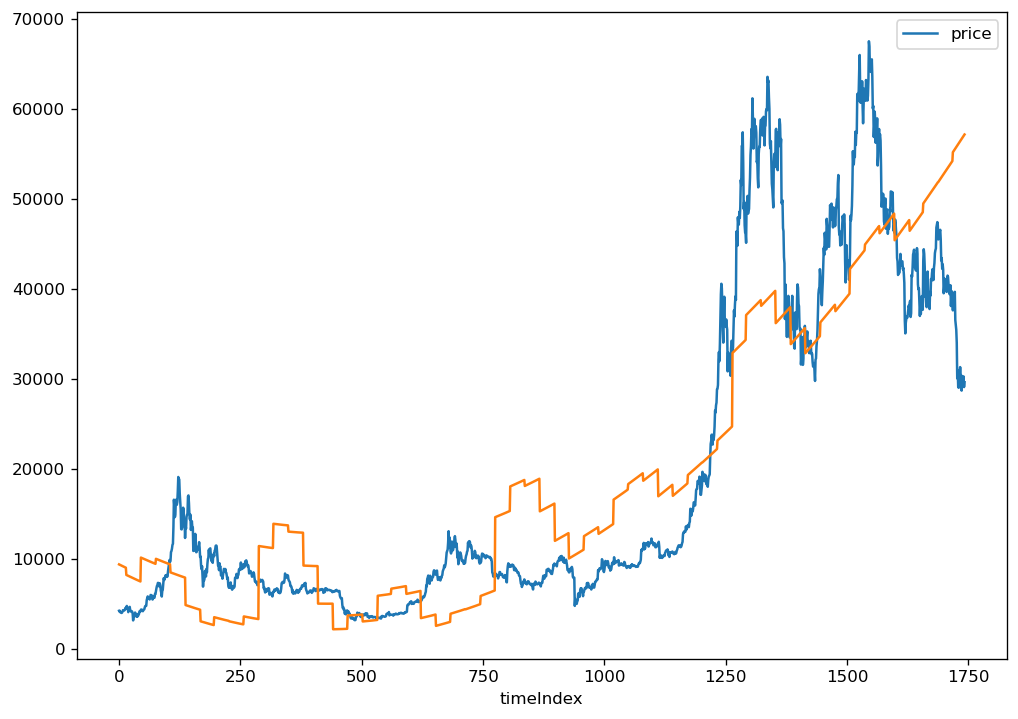

In [127]:
# Ploteamos los resultados de la predicción:

df16_train.plot(kind = "line", x = "timeIndex", y = "price")
plt.plot(df16_train.timeIndex, model_trend_est_pred_train, '-');

In [128]:
# Veamos las predicciones del modelo sobre el set de testeo:

model_trend_est_pred_test = model_trend_est.predict(df16_test[["timeIndex", "timeIndex_sq",\
                                                               "t1", "t2", "t3", "t4",\
                                                                "t5", "t6", "t7",\
                                                                "t8", "t9", "t10", "t11",\
                                                                "t12", "t13", "t14", "t15"]])
model_trend_est_pred_test[-5:]

time
2031-04-02    656855.382187
2031-04-03    657141.885597
2031-04-04    657428.451981
2031-04-05    657715.081341
2031-04-06    658001.773675
dtype: float64

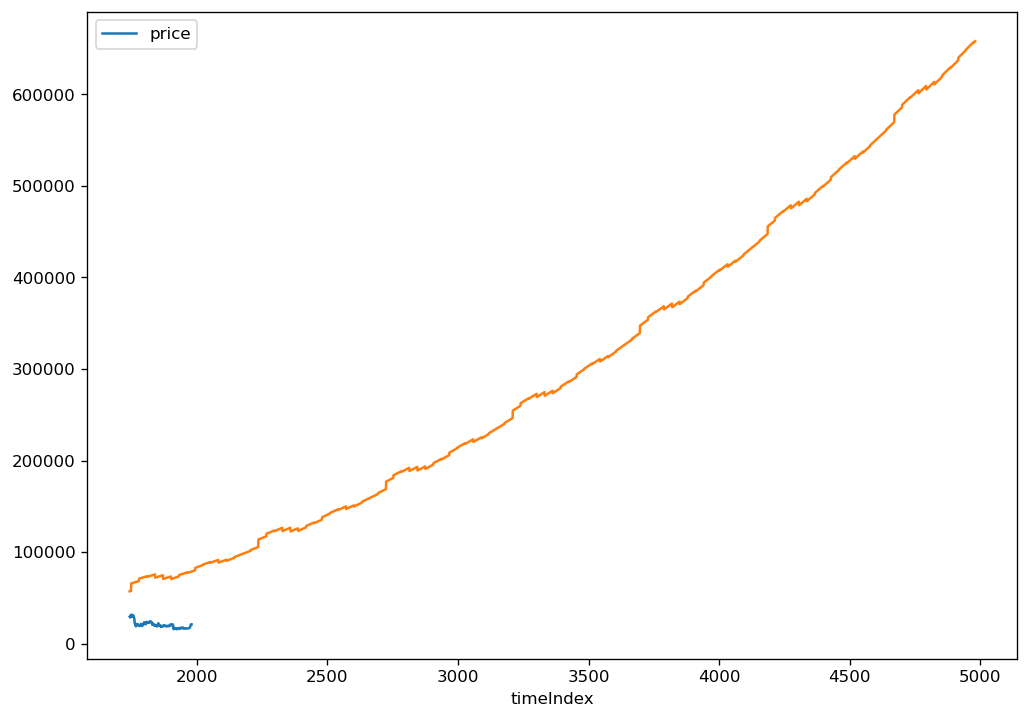

In [129]:
# Ploteamos los resultados de la predicción:

df16_test.plot(kind = "line", x = "timeIndex", y = "price")
plt.plot(df16_test.timeIndex, model_trend_est_pred_test, '-');

In [130]:
# pip install prophet
from prophet import Prophet
import pandas as pd

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


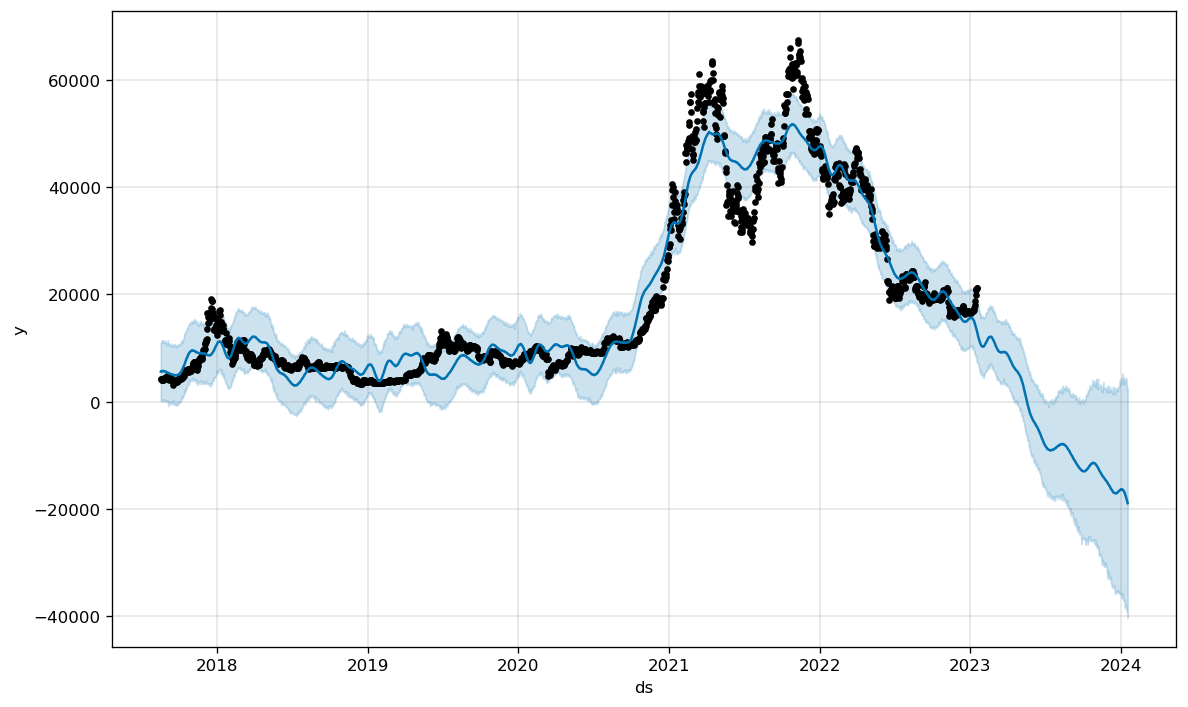

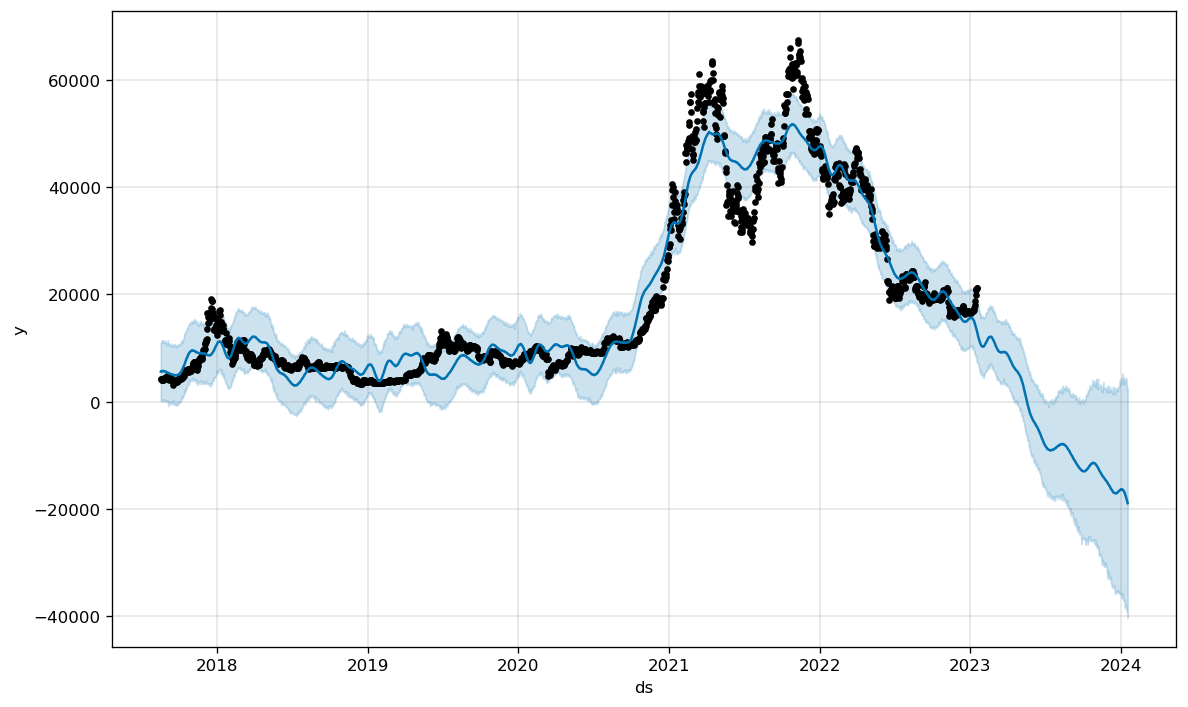

In [131]:
# Load the time series data 
data = pd.read_csv("dff.csv")

# Prepare su conjunto de datos, con una columna "ds" que contenga las fechas y una columna "y" que contenga los valores a predecir.
data = data.rename(columns={"time": "ds", "price": "y"})

# Fit the Prophet model

# Cree una instancia de Prophet 
model = Prophet()
# Entrene el modelo con su conjunto de datos
model.fit(data)

# Cree un DataFrame para hacer predicciones
future = model.make_future_dataframe(periods=365) # "periods" es el número de períodos en el futuro que desea predecir.

# Haga las predicciones
forecast = model.predict(future)

# Grafique las predicciones
model.plot(forecast)